In [157]:
import pandas as pd
import numpy as np
import collections

import os

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## image preprocessing
import cv2
import albumentations as A
import imageio
from PIL import Image, ImageOps, ImageFilter
import matplotlib.image as mpimg
from keras.preprocessing import image

## for metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

## for clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## for data augmentation
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## for CNN
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
import tensorflow as tf

from tqdm import tqdm
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [201]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span class="bg-primary">A.TESTS : CNN<span>

## <span class="bg-danger">0. Fonctions utiles<span>

In [3]:
def path(image):
    
    image = "Images/" + image
    
    return image

In [4]:
def extract(image):
   
    im = Image.open(image)
    file_dir=os.path.split(image)
    
    im.save("Images/"+file_dir[1])
    
    return "Images/"+file_dir[1]

In [5]:
def redimension(image):
    size = 224, 224
    # On charge l'image d'origine
    im = Image.open(image)
    file_dir=os.path.split(image)
    #L'un des côté de l'image fait 224, on garde le ratio original(pas de déformation)
    im.thumbnail(size, Image.ANTIALIAS)
    # On enregistre dans un nouveau dossier l'image redimensionnée.
    im.save("Images_redimension/"+file_dir[1])
    
    #Centrage
    im = Image.open("Images_redimension/"+file_dir[1])
    width, height = im.size
    
    if height > width:
        img = Image.new('RGB', (224, 224),(255,255,255)) # white
        position_larg = int((height - width) / 2)
        img.paste(im, box=(position_larg,0))
        img.save("Images_redimension/"+file_dir[1])
        
    elif width > height:
        img = Image.new('RGB', (224, 224),(255,255,255)) # white
        position_haut = int((width - height) / 2)
        img.paste(im, box=(0, position_haut))
        img.save("Images_redimension/"+file_dir[1])
    
    return "Images_redimension/"+file_dir[1]

In [6]:
def extract_data(col):
    v = np.column_stack(df_image[col].values.tolist())
    df = pd.DataFrame(v).T
    
    return df

In [7]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_pred.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

In [8]:
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df_image = df[['image','product_category_tree']]
df_image['cat_1']=df_image['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])
del df_image['product_category_tree']
df_image["image"] = df_image["image"].apply(path)
df_image["image"] = df_image["image"].apply(extract)
df_image["image_redimension"] = df_image["image"].apply(redimension)

## <span class="bg-info">1. VGG16<span>

In [8]:
# Modèle, extraction des features
vgg16_feature_list = []

model = VGG16(weights='imagenet', include_top=False)
model.summary()
for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())
        
vgg16_feature_list_np = np.array(vgg16_feature_list)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [9]:
#Extraction des données du dataframe
df_image["VGG16"] =  ""

for i in range(df_image.shape[0]):
    df_image["VGG16"][i] = vgg16_feature_list_np[i]
    
df_VGG16 = extract_data("VGG16")
print("Taille vecteurs VGG16 :", df_VGG16.shape[1])

df_image.head()

image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

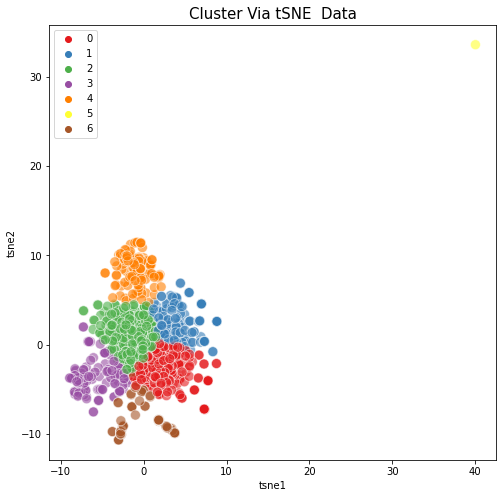

Adjusted Rand Index: 0.318


In [12]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_VGG16)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_VGG16'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_VGG16']
from sklearn import metrics
ari_VGG16 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [14]:
df_image.groupby('cluster_VGG16')['cat_1'].value_counts().to_frame()

cat_1
cluster_VGG16 cat_1                            
0             Home Furnishing                98
              Baby Care                      93
              Home Decor & Festive Needs     19
              Beauty and Personal Care       15
              Computers                       8
1             Kitchen & Dining               40
              Home Furnishing                28
              Baby Care                      21
              Home Decor & Festive Needs     20
              Computers                      19
              Beauty and Personal Care        4
              Watches                         3
2             Computers                     106
              Home Decor & Festive Needs    100
              Baby Care                      31
              Kitchen & Dining               29
              Beauty and Personal Care       25
              Home Furnishing                21
              Watches                         9
3             Beauty and Personal Care      101
              Computers                      15
              Kitchen & Dining                6
              Home Decor & Festive Needs      3
              Baby Care                       2
              Home Furnishing                 2
4             Watches                       138
              Home Decor & Festive Needs      2
5             Home Furnishing                 1
6             Kitchen & Dining               75
              Home Decor & Festive Needs      6
              Beauty and Personal Care        5
              Baby Care                       3
              Computers                       2


accuracy: 50.86%


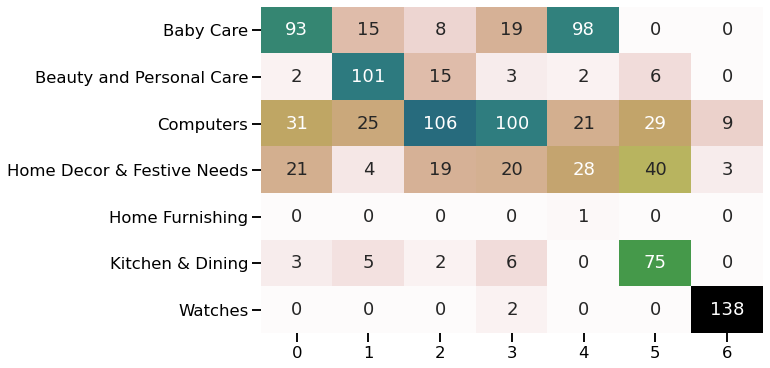

                            precision    recall  f1-score   support

                 Baby Care       0.62      0.40      0.49       233
  Beauty and Personal Care       0.67      0.78      0.72       129
                 Computers       0.71      0.33      0.45       321
Home Decor & Festive Needs       0.13      0.15      0.14       135
           Home Furnishing       0.01      1.00      0.01         1
          Kitchen & Dining       0.50      0.82      0.62        91
                   Watches       0.92      0.99      0.95       140

                  accuracy                           0.51      1050
                 macro avg       0.51      0.64      0.48      1050
              weighted avg       0.62      0.51      0.53      1050



In [16]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16']
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16_label'].replace(0, 'Baby Care')
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16_label'].replace(1, 'Home Decor & Festive Needs')
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16_label'].replace(2, 'Computers')
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16_label'].replace(3, 'Beauty and Personal Care')
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16_label'].replace(4, 'Watches')
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16_label'].replace(5, 'Home Furnishing')
df_image['cluster_VGG16_label'] = df_image['cluster_VGG16_label'].replace(6, 'Kitchen & Dining')
categories_predict = df_image['cluster_VGG16_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">2. Xception<span>

### <span class="bg-success"> Modèle<span> 

In [143]:
from keras.applications.xception import preprocess_input
from keras.applications import Xception
model = Xception(include_top=False, weights="imagenet")
model.summary()

xception_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    xception_feature = model.predict(img_data)
    xception_feature_np = np.array(xception_feature)
    xception_feature_list.append(xception_feature_np.flatten())
        
xception_feature_list_np = np.array(xception_feature_list)

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [144]:
#Extraction des données du dataframe
df_image["Xception"] =  ""

for i in range(df_image.shape[0]):
    df_image["Xception"][i] = xception_feature_list_np[i]
    
df_Xception = extract_data("Xception")
print("Taille vecteurs Xception :", df_Xception.shape[1])

df_image.head()

Taille vecteurs Xception : 100352


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                     augmented_image  \
0  Albumentation/55b85ea15a1536d46b7190ad6fff8ce7...   
1  Albumentation/7b72c92c2f6c40268628ec5f14c6d590...   
2  Albumentation/64d5d4a258243731dc7bbb1eef49ad74...   
3  Albumentation/d4684dcdc759dd9cdf41504698d737d8...   
4  Albumentation/6325b6870c54cd47be6ebfbffa620ec7...   

                                            Xception  cluster_Xception  \
0  [0.011630058, 0.0, 0.14416969, 0.075834095, 0....                 6   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 5   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

   cluster_Total5    cluster_Xception_label  
0               1                 Baby Care  
1               6          Kitchen & Dining  
2               6  Beauty and Personal Care  
3               1                 Baby Care  
4               1                 Baby Care

### <span class="bg-success"> Clustering<span> 

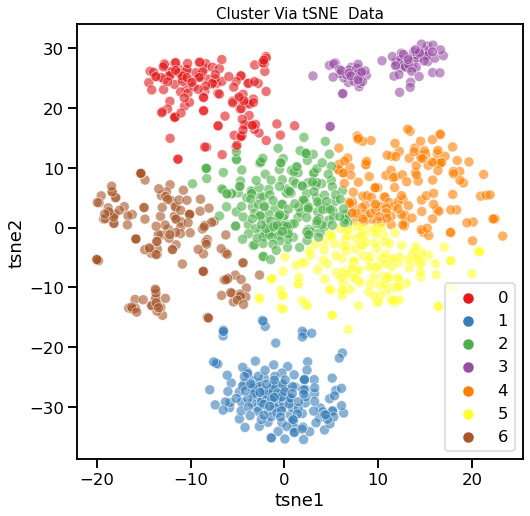

Adjusted Rand Index: 0.465


In [145]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_Xception)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_Xception'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_Xception']
from sklearn import metrics
ari_Xception = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [26]:
#df_Xception.to_csv('Xception.csv')

In [147]:
df_image.groupby('cluster_Xception')['cat_1'].value_counts().to_frame()

cat_1
cluster_Xception cat_1                            
0                Beauty and Personal Care      113
                 Kitchen & Dining               16
                 Baby Care                       5
                 Home Decor & Festive Needs      2
1                Watches                       149
                 Home Decor & Festive Needs     12
                 Kitchen & Dining                4
                 Beauty and Personal Care        3
                 Computers                       1
2                Home Furnishing                91
                 Home Decor & Festive Needs     37
                 Computers                      23
                 Baby Care                      22
                 Beauty and Personal Care       18
                 Kitchen & Dining               10
3                Kitchen & Dining               79
                 Baby Care                       3
                 Beauty and Personal Care        1
4                Home Decor & Festive Needs     81
                 Home Furnishing                42
                 Baby Care                      14
                 Beauty and Personal Care        6
                 Kitchen & Dining                2
                 Computers                       1
                 Watches                         1
5                Baby Care                     106
                 Home Decor & Festive Needs     17
                 Home Furnishing                17
                 Kitchen & Dining                9
                 Computers                       7
                 Beauty and Personal Care        4
6                Computers                     118
                 Kitchen & Dining               30
                 Beauty and Personal Care        5
                 Home Decor & Festive Needs      1


accuracy: 70.19%


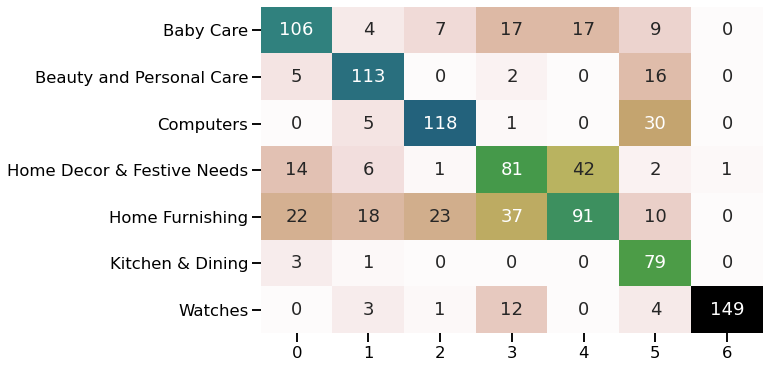

                            precision    recall  f1-score   support

                 Baby Care       0.71      0.66      0.68       160
  Beauty and Personal Care       0.75      0.83      0.79       136
                 Computers       0.79      0.77      0.78       154
Home Decor & Festive Needs       0.54      0.55      0.55       147
           Home Furnishing       0.61      0.45      0.52       201
          Kitchen & Dining       0.53      0.95      0.68        83
                   Watches       0.99      0.88      0.93       169

                  accuracy                           0.70      1050
                 macro avg       0.70      0.73      0.70      1050
              weighted avg       0.71      0.70      0.70      1050



In [148]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_Xception_label'] = df_image['cluster_Xception']
df_image['cluster_Xception_label'] = df_image['cluster_Xception_label'].replace(0, 'Beauty and Personal Care')
df_image['cluster_Xception_label'] = df_image['cluster_Xception_label'].replace(1, 'Watches')
df_image['cluster_Xception_label'] = df_image['cluster_Xception_label'].replace(2, 'Home Furnishing')
df_image['cluster_Xception_label'] = df_image['cluster_Xception_label'].replace(3, 'Kitchen & Dining')
df_image['cluster_Xception_label'] = df_image['cluster_Xception_label'].replace(4, 'Home Decor & Festive Needs')
df_image['cluster_Xception_label'] = df_image['cluster_Xception_label'].replace(5, 'Baby Care')
df_image['cluster_Xception_label'] = df_image['cluster_Xception_label'].replace(6, 'Computers')
categories_predict = df_image['cluster_Xception_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

In [188]:
#Sankey vue d'ensemble
source = [0, 0, 0, 0, 0, 0, 0,        # Beauty and Personal Care
          1, 1,                       # Watches     
          2, 2, 2,                    # Home furnishing 
          3, 3, 3, 3, 3, 3, 3,        # Kitchen & Dining 
          4, 4, 4, 4, 4, 4,           # Home decor & Festive needs  
          5, 5, 5, 5, 5,              # Baby Care
          6, 6, 6, 6, 6]              # Computers               

target = [7, 8, 9, 10, 11, 12, 13,
          8, 11,  
          9, 11, 12, 
          7, 8, 9, 10, 11, 12, 13,
          7, 8, 9, 11, 12, 13,
          7, 9, 10, 11, 12, 
          8, 9, 11, 12, 13]         

value = [113, 3, 18, 1, 6, 4, 5,
         149, 1, 
         91, 42, 17, 
         16, 4, 10, 79, 2, 9, 30,
         2, 12, 37, 81, 17, 1,
         5, 22, 3, 14, 106,
         1, 23, 1, 7, 118]

label = ['Beauty and Personal Care',#0
         'Watches', #1
         'Home furnishing',#2
         'Kitchen & Dining',#3
         'Home decor & Festive needs', #4
         'Baby Care',#5
         'Computers', #6
         
         'Beauty and Personal Care',#7
         'Watches', #8
         'Home furnishing',#9
         'Kitchen & Dining',#10
         'Home decor & Festive needs', #11
         'Baby Care',#12
         'Computers', #13
          ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',  
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', ]
         
# link data
color_link = ['#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF',
              '#A6E3D7', '#A6E3D7',
              '#FFE18F', '#FFE18F', '#FFE18F',
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7',
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Qualité du clustering, Xception",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

### <span class="bg-success"> Exploration et analyse des erreurs<span> 

In [149]:
mask = df_image['cluster_Xception_label']!=df_image['cat_1']
df_erreurs_Xception = df_image.loc[mask]

In [189]:
df_erreurs_Xception.shape

(313, 7)

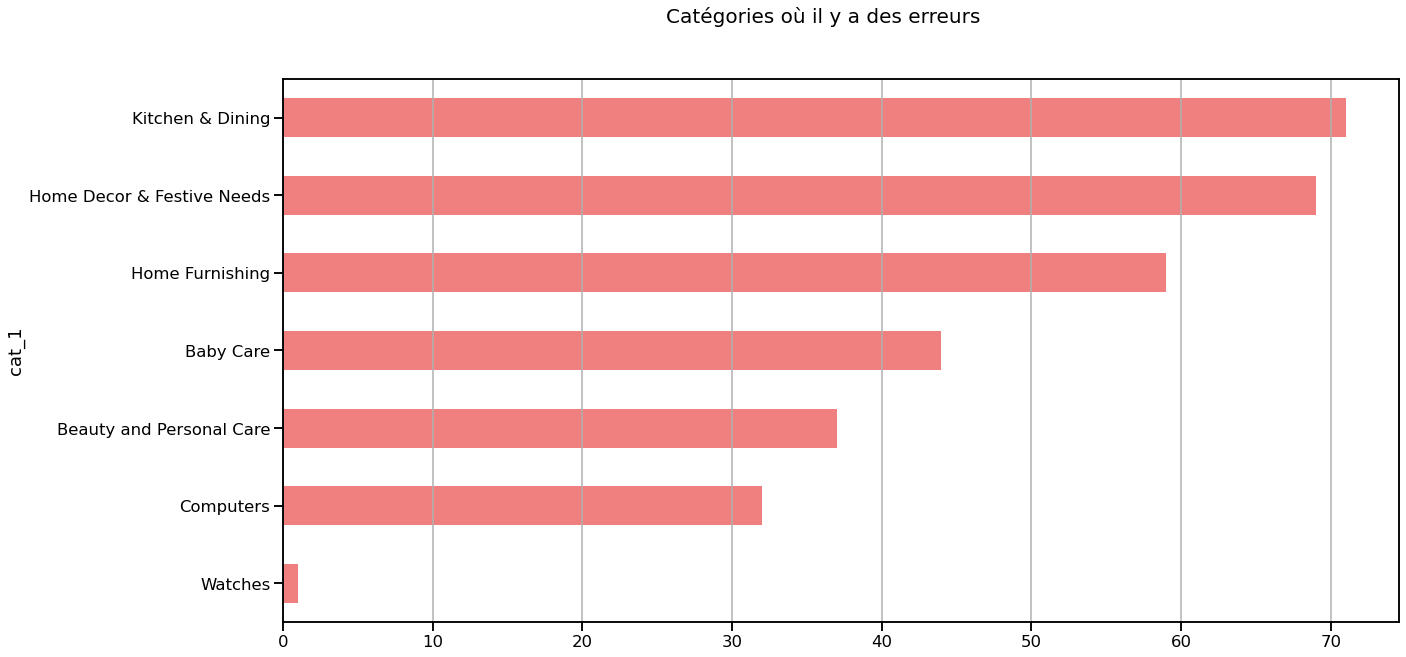

In [185]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Catégories où il y a des erreurs", fontsize=20)
df_erreurs_Xception["cat_1"].reset_index().groupby("cat_1").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, color='lightcoral',
        ax=ax).grid(axis='x')
plt.show()

In [154]:
df_erreurs_Xception.groupby('cluster_Xception_label')['cat_1'].value_counts().to_frame()

cat_1
cluster_Xception_label     cat_1                            
Baby Care                  Home Decor & Festive Needs     17
                           Home Furnishing                17
                           Kitchen & Dining                9
                           Computers                       7
                           Beauty and Personal Care        4
Beauty and Personal Care   Kitchen & Dining               16
                           Baby Care                       5
                           Home Decor & Festive Needs      2
Computers                  Kitchen & Dining               30
                           Beauty and Personal Care        5
                           Home Decor & Festive Needs      1
Home Decor & Festive Needs Home Furnishing                42
                           Baby Care                      14
                           Beauty and Personal Care        6
                           Kitchen & Dining                2
                           Computers                       1
                           Watches                         1
Home Furnishing            Home Decor & Festive Needs     37
                           Computers                      23
                           Baby Care                      22
                           Beauty and Personal Care       18
                           Kitchen & Dining               10
Kitchen & Dining           Baby Care                       3
                           Beauty and Personal Care        1
Watches                    Home Decor & Festive Needs     12
                           Kitchen & Dining                4
                           Beauty and Personal Care        3
                           Computers                       1

In [160]:
#Sankey vue d'ensemble
source = [0, 0, 0, 0, 0,              # Home decor & Festive needs 
          1, 1,                       # Home furnishing    
          2, 2, 2, 2, 2, 2,           # Kitchen & Dining  
          3, 3, 3, 3, 3, 3,           # Beauty and Personal Care
          4, 4, 4, 4,                 # Computers 
          5, 5, 5, 5,                 # Baby Care
          6]                          # Watches               

target = [7, 8, 9, 10, 11, 
          7, 12,  
          7, 8, 9, 12, 10, 11,
          7, 9, 12, 10, 13, 11,
          7, 12, 10, 11,
          8, 12, 10, 13, 
          12]         

value = [17, 2, 1, 37, 12,
         17, 42, 
         9, 16, 30, 2, 1, 10, 4,
         4, 5, 6, 18, 1, 3, 
         7, 1, 23, 1,
         5, 14, 22, 3, 
         1]

label = ['Home decor & Festive needs',#0
         'Home furnishing', #1
         'Kitchen & Dining',#2
         'Beauty and Personal Care',#3
         'Computers', #4
         'Baby Care',#5
         'Watches', #6
         
         'Baby Care',#7
         'Beauty and Personal Care', #8
         'Computers',#9
         'Home furnishing',#10
         'Watches', #11
         'Home decor & Festive needs',#12
         'Kitchen & Dining', #13
          ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',  
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', ]
         
# link data
color_link = ['#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FFE18F','#FFE18F',
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7',
              '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF',  
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',  
              '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',
              '#A6E3D7']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Erreurs, Xception",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

In [182]:
def plot_erreurs(cat_clust, cat_true, figsize=(8,4),
                palette='tab10', ylim=(0,250), bboxtoanchor=None):
    
    # pivot = data.drop(columns=['description','image'])
    pivot = pd.DataFrame()
    pivot['label']=cat_clust
    pivot['category']=cat_true
    pivot['count']=1
    pivot = pivot.groupby(by=['label','category']).count().unstack().fillna(0)
    pivot.columns=pivot.columns.droplevel()
    
    colors = sns.color_palette(palette, cat_clust.shape[0]).as_hex()
    pivot.plot.bar(width=0.8,stacked=True,legend=True,figsize=figsize,
                   color=colors, ec='k')
    plt.legend(bbox_to_anchor=bboxtoanchor)
        
    plt.show()    
    
    return pivot

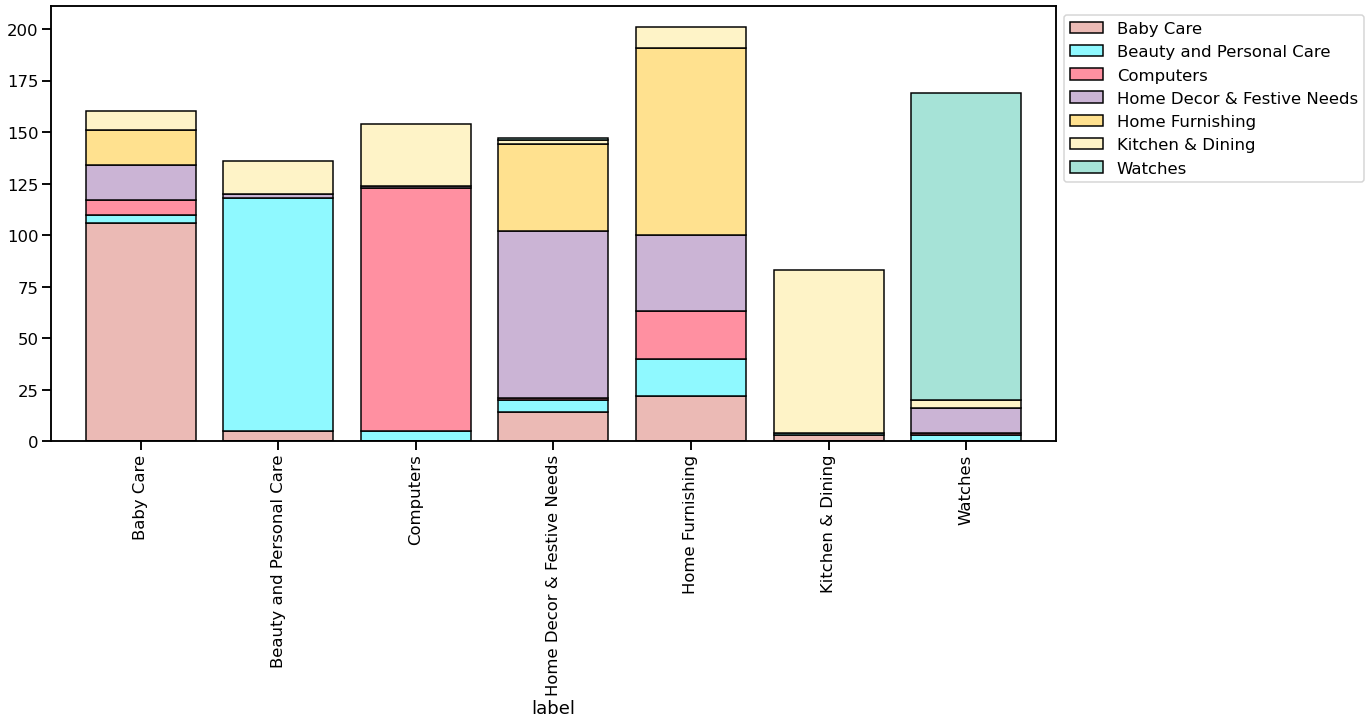

category                    Baby Care  Beauty and Personal Care  Computers  \
label                                                                        
Baby Care                       106.0                       4.0        7.0   
Beauty and Personal Care          5.0                     113.0        0.0   
Computers                         0.0                       5.0      118.0   
Home Decor & Festive Needs       14.0                       6.0        1.0   
Home Furnishing                  22.0                      18.0       23.0   
Kitchen & Dining                  3.0                       1.0        0.0   
Watches                           0.0                       3.0        1.0   

category                    Home Decor & Festive Needs  Home Furnishing  \
label                                                                     
Baby Care                                         17.0             17.0   
Beauty and Personal Care                           2.0              0.0   
Computers                                          1.0              0.0   
Home Decor & Festive Needs                        81.0             42.0   
Home Furnishing                                   37.0             91.0   
Kitchen & Dining                                   0.0              0.0   
Watches                                           12.0              0.0   

category                    Kitchen & Dining  Watches  
label                                                  
Baby Care                                9.0      0.0  
Beauty and Personal Care                16.0      0.0  
Computers                               30.0      0.0  
Home Decor & Festive Needs               2.0      1.0  
Home Furnishing                         10.0      0.0  
Kitchen & Dining                        79.0      0.0  
Watches                                  4.0    149.0

In [184]:
plot_erreurs(df_image['cluster_Xception_label'],
                              df_image['cat_1'],
                              palette=['#EBBAB5', '#8FF9FF', '#FF90A1','#CBB4D5', '#FFE18F','#FEF3C7','#A6E3D7'],
                              figsize=(18,8),
                              bboxtoanchor=(1,1), ylim=(0,250))

In [31]:
Image.MAX_IMAGE_PIXELS = 1000000000 
for ind in df_image.index:
    temp = Image.open(df_image.loc[ind, "image"])
    img = temp.copy()
    df_image.loc[ind, "image"] = "0"
    df_image.loc[ind, "image"] = img
    temp.close()

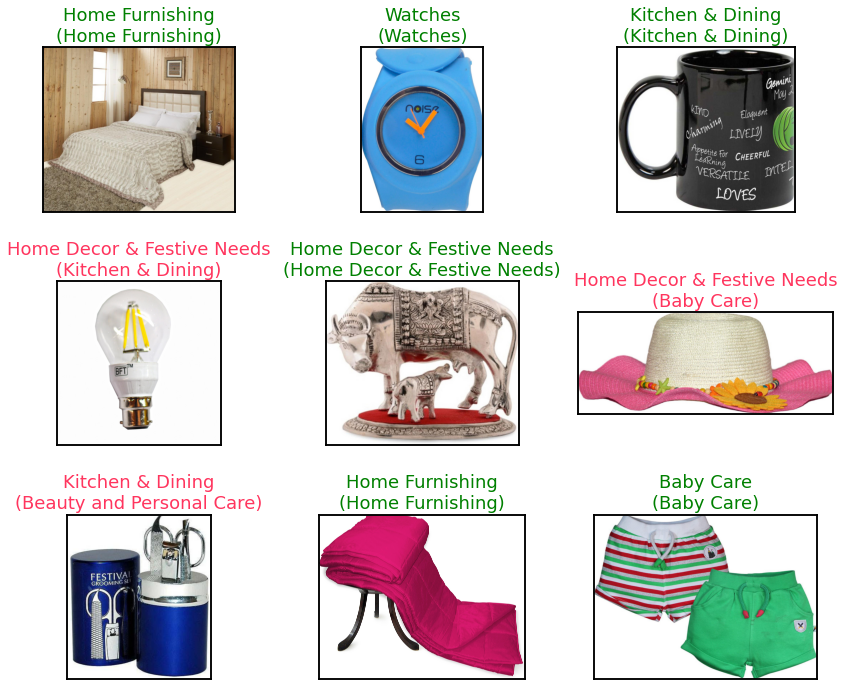

In [42]:
#py_test_cnn=cnn_model.predict_classes(x_test)
fig=plt.figure(figsize=(12,10))
randch=np.random.choice(
    df_image.shape[0],size=9,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
    ax.imshow(df_image.image[idx])
    pred_idx=df_image['cluster_Xception_label'][idx]
    true_idx=df_image.cat_1[idx]
    ti='{}\n({})'.format(pred_idx,true_idx)
    ax.set_title(ti,color=(
        'green' if pred_idx==true_idx else '#ff355e'))
plt.tight_layout()    
plt.show()

In [49]:
df_image["image_redimension"] = df_image["image_redimension"].apply(extract)

In [96]:
def erreurs_visualisation(col_image, erreurs, n_rows=1):

    n_tot = len(erreurs)
    n_cols = (n_tot//n_rows)+((n_tot%n_rows)>0)*1
    fig = plt.figure()
    for i, ind in enumerate(erreurs,1):
        img = col_image.loc[ind]
        ax.imshow(img)
        ax.set_title(li_im_title[i-1], fontsize=30)
        ax.set_axis_off()
    plt.tight_layout()        
    plt.show()

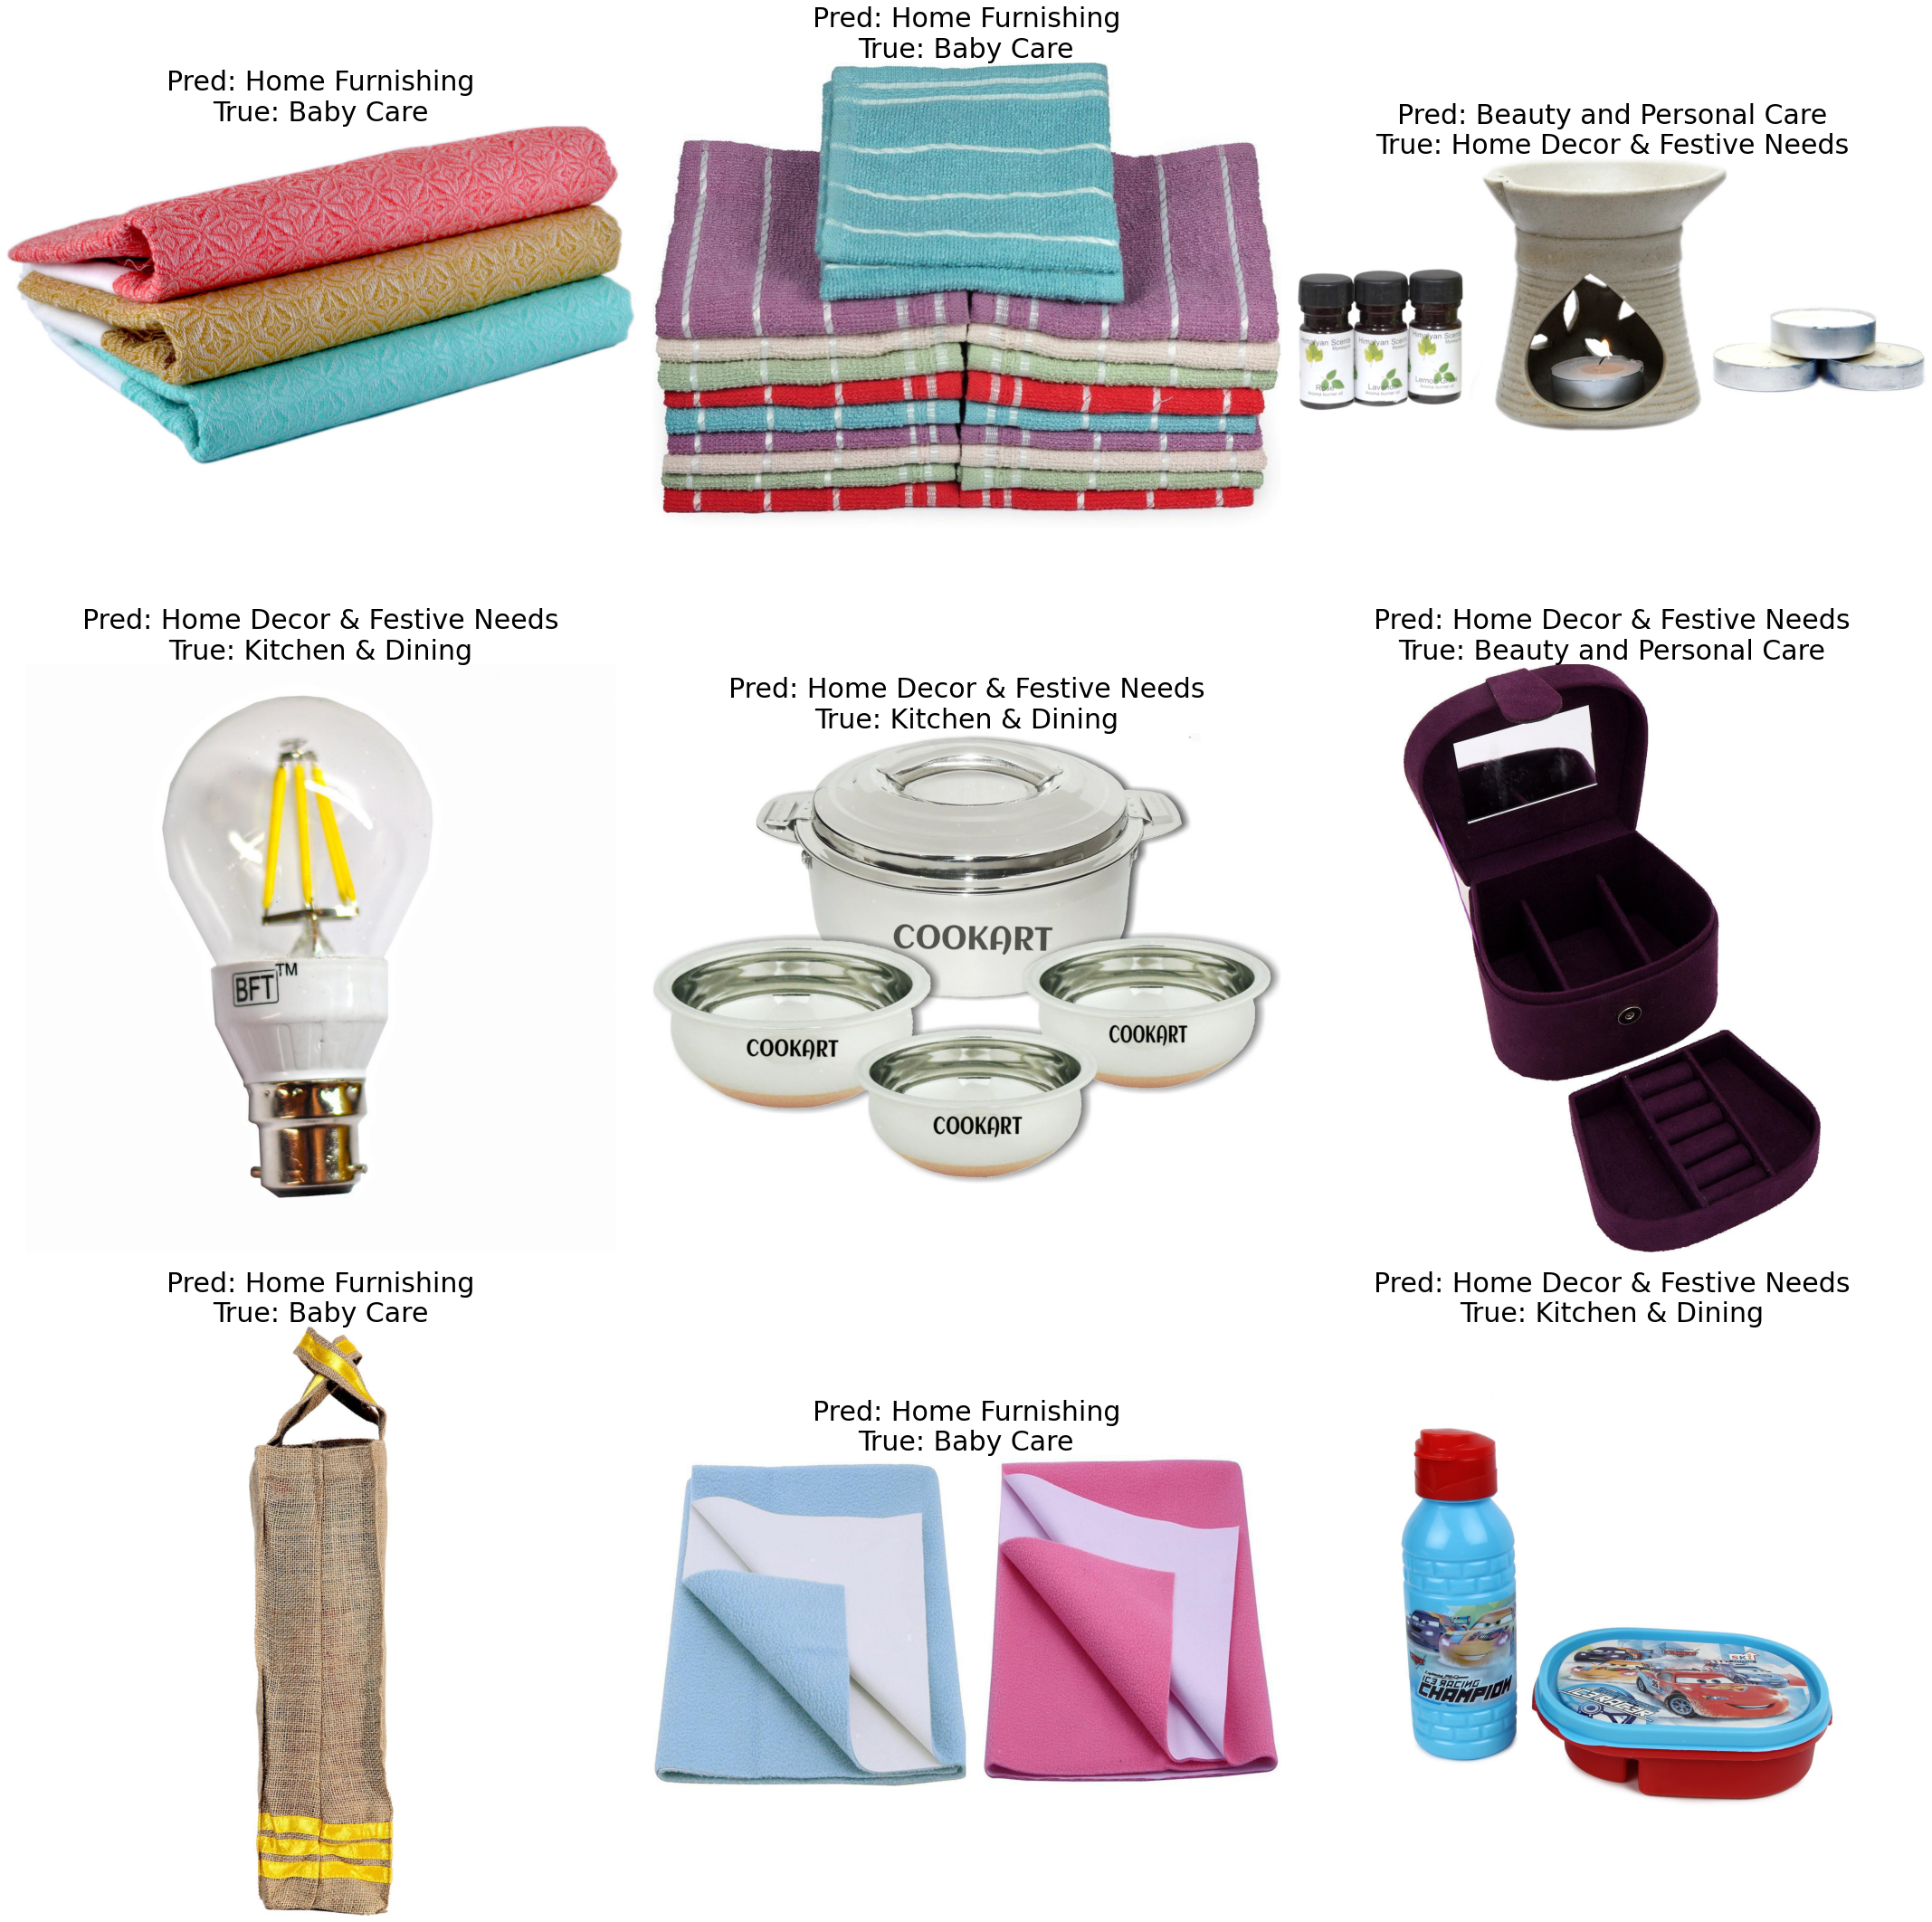

In [99]:
##ERREURS Xception EXEMPLES
mask = df_image['cluster_Xception_label']!=df_image['cat_1']
erreurs_Xception = list(df_image.loc[mask].index)
cat_false = df_image['cluster_Xception_label'].loc[erreurs_Xception]
cat_true = df_image['cat_1'].loc[erreurs_Xception]
li_im_title = [f'Pred: {w}\nTrue: {c}' for w, c in zip(cat_false,cat_true)]

print_thumbnails_from_df(df_image['image'],erreurs_Xception[0:9],
                         n_rows=3, figsize=(30,30),
                         li_im_title=li_im_title,) #title='Xception errors')

## <span class="bg-info">3. MobilNetV2<span>

In [35]:
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications import MobileNetV2
model = MobileNetV2(include_top=False, weights="imagenet")
model.summary()
MobileNetV2_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    MobileNetV2_feature = model.predict(img_data)
    MobileNetV2_feature_np = np.array(MobileNetV2_feature)
    MobileNetV2_feature_list.append(MobileNetV2_feature_np.flatten())
        
MobileNetV2_feature_list_np = np.array(MobileNetV2_feature_list)

9412608/9406464 [==============================] - 6s 1us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
________________

In [36]:
#Extraction des données du dataframe
df_image["MobileNetV2"] =  ""

for i in range(df_image.shape[0]):
    df_image["MobileNetV2"][i] = MobileNetV2_feature_list_np[i]
    
df_MobileNetV2 = extract_data("MobileNetV2")
print("Taille vecteurs MobileNetV2 :", df_MobileNetV2.shape[1])

df_image.head()

Taille vecteurs MobileNetV2 : 62720


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  cluster_MobileNet  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  2   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...                  0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  2   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  6   

      cluster_MobileNet_label  \
0             Home Furnishing   
1             Home Furnishing   
2                   Baby Care   
3             Home Furnishing   
4  Home Decor & Festive Needs   

                                         MobileNetV2  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 2.483614, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8401828,...

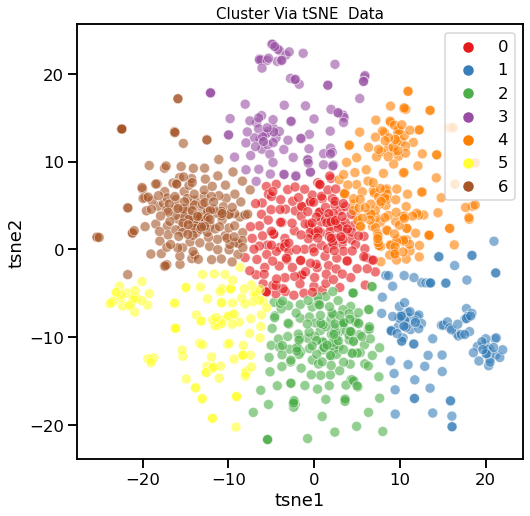

Adjusted Rand Index: 0.356


In [37]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_MobileNetV2)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_MobileNetV2'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_MobileNetV2']
from sklearn import metrics
ari_MobileNetV2 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [38]:
df_image.groupby('cluster_MobileNetV2')['cat_1'].value_counts().to_frame()

cat_1
cluster_MobileNetV2 cat_1                            
0                   Home Furnishing                52
                    Home Decor & Festive Needs     51
                    Baby Care                      41
                    Computers                      20
                    Beauty and Personal Care       10
                    Kitchen & Dining                7
1                   Kitchen & Dining               76
                    Home Furnishing                26
                    Baby Care                       7
                    Computers                       6
                    Beauty and Personal Care        1
                    Home Decor & Festive Needs      1
2                   Beauty and Personal Care      122
                    Computers                      18
                    Kitchen & Dining               16
                    Home Decor & Festive Needs     10
                    Baby Care                       7
                    Home Furnishing                 2
3                   Home Decor & Festive Needs     57
                    Computers                      27
                    Kitchen & Dining                7
                    Home Furnishing                 5
                    Baby Care                       3
                    Beauty and Personal Care        3
4                   Baby Care                      85
                    Home Furnishing                65
                    Home Decor & Festive Needs     11
                    Computers                       8
                    Beauty and Personal Care        2
5                   Computers                      60
                    Kitchen & Dining               32
                    Home Decor & Festive Needs     12
                    Beauty and Personal Care       10
                    Baby Care                       3
6                   Watches                       150
                    Kitchen & Dining               12
                    Computers                      11
                    Home Decor & Festive Needs      8
                    Baby Care                       4
                    Beauty and Personal Care        2


accuracy: 57.33%


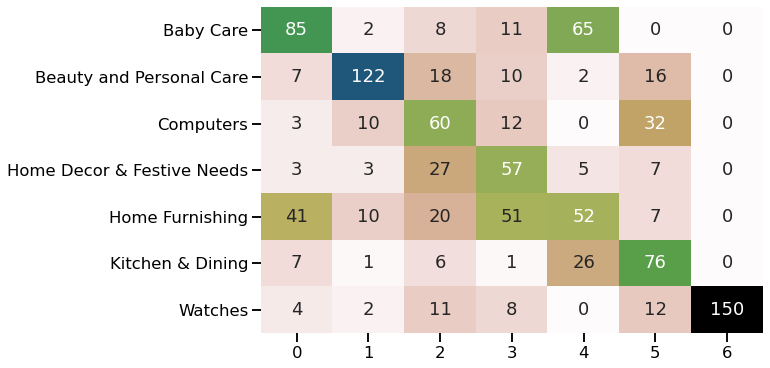

                            precision    recall  f1-score   support

                 Baby Care       0.57      0.50      0.53       171
  Beauty and Personal Care       0.81      0.70      0.75       175
                 Computers       0.40      0.51      0.45       117
Home Decor & Festive Needs       0.38      0.56      0.45       102
           Home Furnishing       0.35      0.29      0.31       181
          Kitchen & Dining       0.51      0.65      0.57       117
                   Watches       1.00      0.80      0.89       187

                  accuracy                           0.57      1050
                 macro avg       0.57      0.57      0.57      1050
              weighted avg       0.60      0.57      0.58      1050



In [43]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2']
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2_label'].replace(0, 'Home Furnishing')
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2_label'].replace(1, 'Kitchen & Dining')
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2_label'].replace(2, 'Beauty and Personal Care')
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2_label'].replace(3, 'Home Decor & Festive Needs')
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2_label'].replace(4, 'Baby Care')
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2_label'].replace(5, 'Computers')
df_image['cluster_MobileNetV2_label'] = df_image['cluster_MobileNetV2_label'].replace(6, 'Watches')
categories_predict = df_image['cluster_MobileNetV2_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">4. MobilNet<span>

In [39]:
from keras.applications.mobilenet import preprocess_input
from keras.applications import MobileNet
model = MobileNet(include_top=False, weights="imagenet")
model.summary()
MobileNet_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    MobileNet_feature = model.predict(img_data)
    MobileNet_feature_np = np.array(MobileNet_feature)
    MobileNet_feature_list.append(MobileNet_feature_np.flatten())
        
MobileNet_feature_list_np = np.array(MobileNet_feature_list)

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [40]:
#Extraction des données du dataframe
df_image["MobileNet"] =  ""

for i in range(df_image.shape[0]):
    df_image["MobileNet"][i] = MobileNet_feature_list_np[i]
    
df_MobileNet = extract_data("MobileNet")
print("Taille vecteurs MobileNet :", df_MobileNet.shape[1])

df_image.head()

Taille vecteurs MobileNet : 50176


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  cluster_MobileNet  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  2   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...                  0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  2   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  6   

      cluster_MobileNet_label  \
0             Home Furnishing   
1             Home Furnishing   
2                   Baby Care   
3             Home Furnishing   
4  Home Decor & Festive Needs   

                                         MobileNetV2  cluster_MobileNetV2  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                    1  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                    0  
2  [0.0, 0.0, 0.0, 2.483614, 0.0, 0.0, 0.0, 0.0, ...                    0  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                    4  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8401828,...                    4

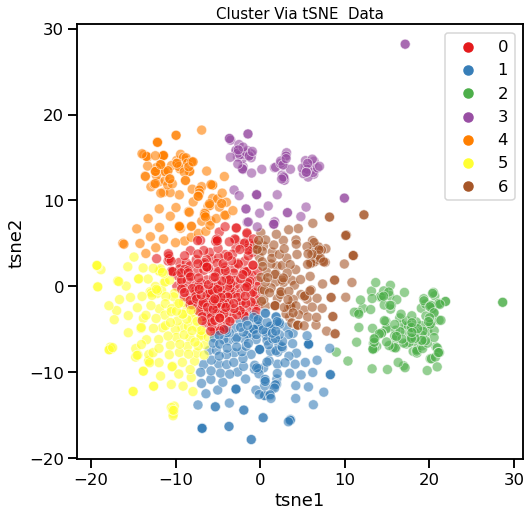

Adjusted Rand Index: 0.359


In [41]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_MobileNet)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_MobileNet'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_MobileNet']
from sklearn import metrics
ari_MobileNet = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [42]:
df_image.groupby('cluster_MobileNet')['cat_1'].value_counts().to_frame()

cat_1
cluster_MobileNet cat_1                            
0                 Baby Care                      84
                  Home Decor & Festive Needs     64
                  Home Furnishing                42
                  Computers                      17
                  Kitchen & Dining               13
                  Beauty and Personal Care        7
1                 Computers                      96
                  Home Furnishing                25
                  Beauty and Personal Care       18
                  Home Decor & Festive Needs     18
                  Baby Care                      11
                  Kitchen & Dining                6
                  Watches                         3
2                 Watches                       138
                  Home Decor & Festive Needs      3
3                 Kitchen & Dining               78
                  Home Decor & Festive Needs     12
                  Home Furnishing                 4
                  Beauty and Personal Care        3
                  Baby Care                       1
                  Computers                       1
4                 Beauty and Personal Care      111
                  Baby Care                       7
                  Home Decor & Festive Needs      6
                  Computers                       3
                  Kitchen & Dining                2
5                 Home Furnishing                76
                  Baby Care                      42
                  Home Decor & Festive Needs     14
                  Computers                       6
                  Beauty and Personal Care        3
6                 Kitchen & Dining               51
                  Home Decor & Festive Needs     33
                  Computers                      27
                  Watches                         9
                  Beauty and Personal Care        8
                  Baby Care                       5
                  Home Furnishing                 3


accuracy: 58.67%


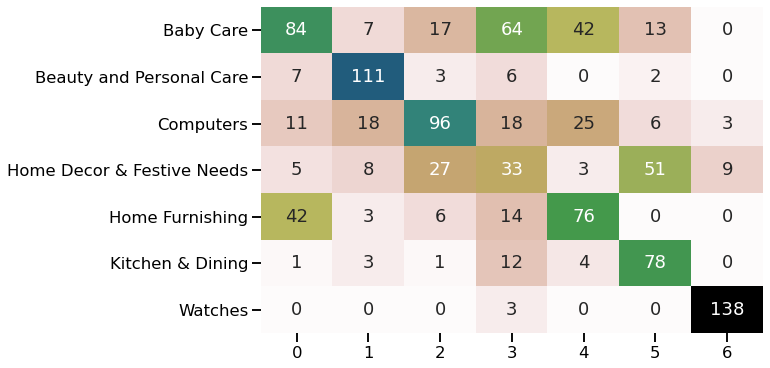

                            precision    recall  f1-score   support

                 Baby Care       0.56      0.37      0.45       227
  Beauty and Personal Care       0.74      0.86      0.80       129
                 Computers       0.64      0.54      0.59       177
Home Decor & Festive Needs       0.22      0.24      0.23       136
           Home Furnishing       0.51      0.54      0.52       141
          Kitchen & Dining       0.52      0.79      0.63        99
                   Watches       0.92      0.98      0.95       141

                  accuracy                           0.59      1050
                 macro avg       0.59      0.62      0.59      1050
              weighted avg       0.59      0.59      0.58      1050



In [44]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet']
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet_label'].replace(0, 'Baby Care')
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet_label'].replace(1, 'Computers')
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet_label'].replace(2, 'Watches')
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet_label'].replace(3, 'Kitchen & Dining')
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet_label'].replace(4, 'Beauty and Personal Care')
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet_label'].replace(5, 'Home Furnishing')
df_image['cluster_MobileNet_label'] = df_image['cluster_MobileNet_label'].replace(6, 'Home Decor & Festive Needs')
categories_predict = df_image['cluster_MobileNet_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">5. ResNet50V2<span>

In [45]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
model = ResNet50V2(include_top=False, weights="imagenet")
model.summary()
ResNet50V2_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    ResNet50V2_feature = model.predict(img_data)
    ResNet50V2_feature_np = np.array(ResNet50V2_feature)
    ResNet50V2_feature_list.append(ResNet50V2_feature_np.flatten())
        
ResNet50V2_feature_list_np = np.array(ResNet50V2_feature_list)

94674944/94668760 [==============================] - 65s 1us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_______________________

In [46]:
#Extraction des données du dataframe
df_image["ResNet50V2"] =  ""

for i in range(df_image.shape[0]):
    df_image["ResNet50V2"][i] = ResNet50V2_feature_list_np[i]
    
df_ResNet50V2 = extract_data("ResNet50V2")
print("Taille vecteurs ResNet50V2 :", df_ResNet50V2.shape[1])

df_image.head()

Taille vecteurs ResNet50V2 : 100352


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  cluster_MobileNet  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  5   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...                  0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  1   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  5   

  cluster_MobileNet_label                                        MobileNetV2  \
0         Home Furnishing  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1               Baby Care  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2               Baby Care  [0.0, 0.0, 0.0, 2.483614, 0.0, 0.0, 0.0, 0.0, ...   
3               Computers  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4         Home Furnishing  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8401828,...   

   cluster_MobileNetV2 cluster_MobileNetV2_label  \
0                    1          Kitchen & Dining   
1                    0           Home Furnishing   
2                    0           Home Furnishing   
3                    4                 Baby Care   
4                    4                 Baby Care   

                                          ResNet50V2  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

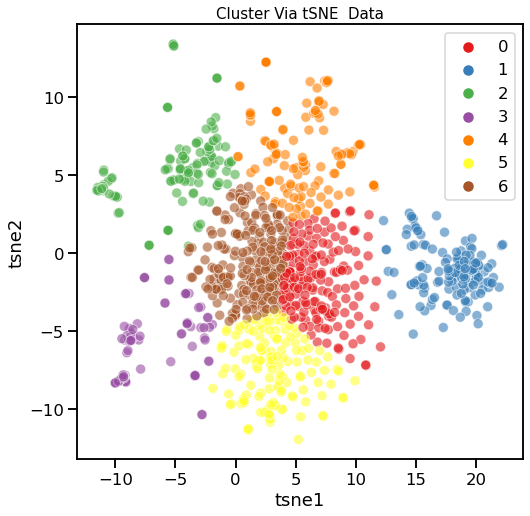

Adjusted Rand Index: 0.331


In [49]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_ResNet50V2)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_ResNet50V2'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_ResNet50V2']
from sklearn import metrics
ari_ResNet50V2 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [65]:
df_image.groupby('cluster_ResNet50V2')['cat_1'].value_counts().to_frame()

cat_1
cluster_ResNet50V2 cat_1                            
0                  Home Decor & Festive Needs     99
                   Computers                      17
                   Kitchen & Dining               14
                   Home Furnishing                13
                   Beauty and Personal Care       11
                   Watches                        10
                   Baby Care                       9
1                  Watches                       140
                   Home Decor & Festive Needs      3
                   Beauty and Personal Care        2
2                  Beauty and Personal Care       84
                   Kitchen & Dining               43
                   Computers                      12
                   Baby Care                       2
                   Home Decor & Festive Needs      1
3                  Kitchen & Dining               44
                   Home Furnishing                30
                   Baby Care                       5
                   Computers                       2
                   Home Decor & Festive Needs      2
4                  Computers                      86
                   Kitchen & Dining               31
                   Beauty and Personal Care       10
                   Home Decor & Festive Needs      2
                   Baby Care                       1
5                  Baby Care                      84
                   Home Furnishing                28
                   Home Decor & Festive Needs     23
                   Beauty and Personal Care        3
                   Kitchen & Dining                2
                   Computers                       1
6                  Home Furnishing                79
                   Baby Care                      49
                   Beauty and Personal Care       40
                   Computers                      32
                   Home Decor & Festive Needs     20
                   Kitchen & Dining               16


accuracy: 58.67%


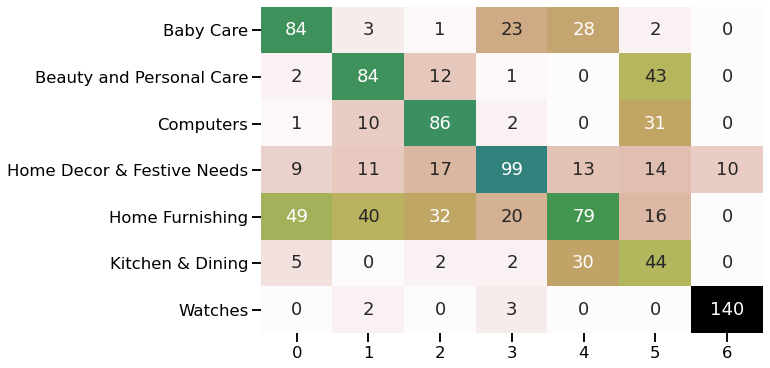

                            precision    recall  f1-score   support

                 Baby Care       0.56      0.60      0.58       141
  Beauty and Personal Care       0.56      0.59      0.58       142
                 Computers       0.57      0.66      0.61       130
Home Decor & Festive Needs       0.66      0.57      0.61       173
           Home Furnishing       0.53      0.33      0.41       236
          Kitchen & Dining       0.29      0.53      0.38        83
                   Watches       0.93      0.97      0.95       145

                  accuracy                           0.59      1050
                 macro avg       0.59      0.61      0.59      1050
              weighted avg       0.60      0.59      0.59      1050



In [66]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2']
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2_label'].replace(0, 'Home Decor & Festive Needs')
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2_label'].replace(1, 'Watches')
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2_label'].replace(2, 'Beauty and Personal Care')
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2_label'].replace(3, 'Kitchen & Dining')
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2_label'].replace(4, 'Computers')
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2_label'].replace(5, 'Baby Care')
df_image['cluster_ResNet50V2_label'] = df_image['cluster_ResNet50V2_label'].replace(6, 'Home Furnishing')
categories_predict = df_image['cluster_ResNet50V2_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">6. EfficientNet<span>

### B1

In [51]:
from tensorflow.keras.applications import EfficientNetB1
model = Sequential(EfficientNetB1(weights='imagenet', include_top=False))
model.summary()

EfficientNetB1_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = tf.keras.applications.efficientnet.preprocess_input(img_data)

    EfficientNetB1_feature = model.predict(img_data)
    EfficientNetB1_feature_np = np.array(EfficientNetB1_feature)
    EfficientNetB1_feature_list.append(EfficientNetB1_feature_np.flatten())
        
EfficientNetB1_feature_list_np = np.array(EfficientNetB1_feature_list)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, None, None, 1280)  6575239   
Total params: 6,575,239
Trainable params: 6,513,184
Non-trainable params: 62,055
_________________________________________________________________


In [53]:
#Extraction des données du dataframe
df_image["EfficientNetB1"] =  ""

for i in range(df_image.shape[0]):
    df_image["EfficientNetB1"][i] = EfficientNetB1_feature_list_np[i]
    
df_EfficientNetB1 = extract_data("EfficientNetB1")
print("Taille vecteurs EfficientNetB1 :", df_EfficientNetB1.shape[1])

df_image.head()

Taille vecteurs EfficientNetB1 : 62720


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  cluster_MobileNet  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  5   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...                  0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  1   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  5   

  cluster_MobileNet_label                                        MobileNetV2  \
0         Home Furnishing  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1               Baby Care  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2               Baby Care  [0.0, 0.0, 0.0, 2.483614, 0.0, 0.0, 0.0, 0.0, ...   
3               Computers  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4         Home Furnishing  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8401828,...   

   cluster_MobileNetV2 cluster_MobileNetV2_label  \
0                    1          Kitchen & Dining   
1                    0           Home Furnishing   
2                    0           Home Furnishing   
3                    4                 Baby Care   
4                    4                 Baby Care   

                                          ResNet50V2  cluster_ResNet50V2  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   3   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   

                                      EfficientNetB1  
0  [0.7876732, -0.03521527, -0.27812046, -0.02225...  
1  [0.9073939, -0.05119571, -0.02147754, -0.08282...  
2  [4.289804, -0.066495046, -0.012661189, -0.1623...  
3  [0.28327495, -0.25650352, -0.2779455, -0.13232...  
4  [-0.27664414, -0.039328925, -0.09437825, -0.13...

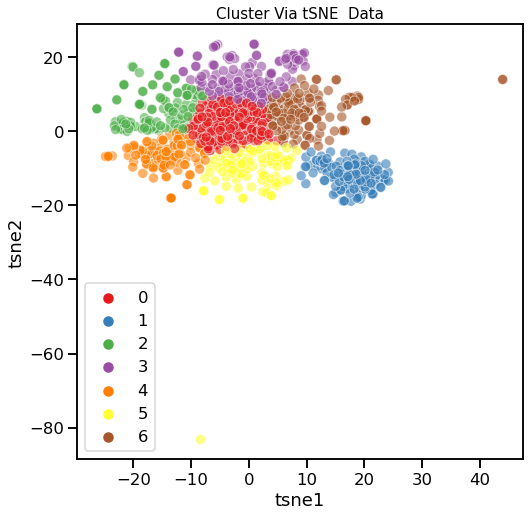

Adjusted Rand Index: 0.283


In [56]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_EfficientNetB1)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_EfficientNetB1'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_EfficientNetB1']
from sklearn import metrics
ari_EfficientNetB1 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [57]:
df_image.groupby('cluster_EfficientNetB1')['cat_1'].value_counts().to_frame()

cat_1
cluster_EfficientNetB1 cat_1                            
0                      Home Furnishing                59
                       Home Decor & Festive Needs     42
                       Kitchen & Dining               41
                       Baby Care                      35
                       Beauty and Personal Care       26
                       Computers                      23
                       Watches                         1
1                      Watches                       148
                       Computers                       4
                       Home Decor & Festive Needs      4
                       Beauty and Personal Care        3
2                      Kitchen & Dining               52
                       Home Furnishing                23
                       Beauty and Personal Care       19
                       Computers                      18
                       Home Decor & Festive Needs     12
                       Baby Care                       4
                       Watches                         1
3                      Home Furnishing                61
                       Computers                      41
                       Baby Care                      20
                       Home Decor & Festive Needs     19
                       Kitchen & Dining                6
                       Beauty and Personal Care        3
4                      Beauty and Personal Care       94
                       Kitchen & Dining               19
                       Computers                      16
                       Baby Care                       2
                       Home Decor & Festive Needs      1
                       Home Furnishing                 1
5                      Home Decor & Festive Needs     46
                       Kitchen & Dining               30
                       Computers                      23
                       Baby Care                       3
                       Home Furnishing                 2
6                      Baby Care                      86
                       Home Decor & Festive Needs     26
                       Computers                      25
                       Beauty and Personal Care        5
                       Home Furnishing                 4
                       Kitchen & Dining                2


accuracy: 50.1%


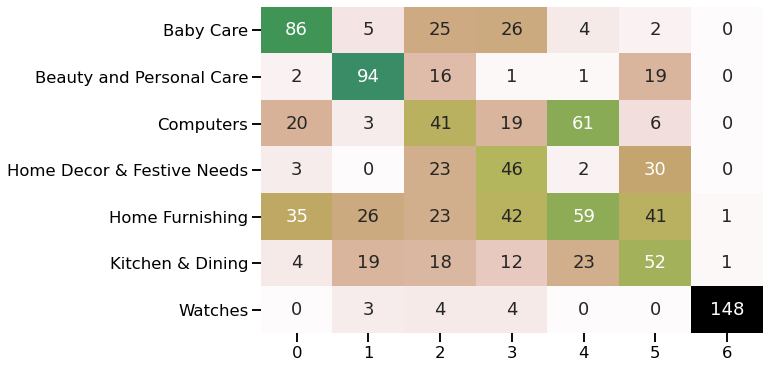

                            precision    recall  f1-score   support

                 Baby Care       0.57      0.58      0.58       148
  Beauty and Personal Care       0.63      0.71      0.66       133
                 Computers       0.27      0.27      0.27       150
Home Decor & Festive Needs       0.31      0.44      0.36       104
           Home Furnishing       0.39      0.26      0.31       227
          Kitchen & Dining       0.35      0.40      0.37       129
                   Watches       0.99      0.93      0.96       159

                  accuracy                           0.50      1050
                 macro avg       0.50      0.51      0.50      1050
              weighted avg       0.51      0.50      0.50      1050



In [60]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1']
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(0, 'Home Furnishing')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(1, 'Watches')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(2, 'Kitchen & Dining')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(3, 'Computers')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(4, 'Beauty and Personal Care')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(5, 'Home Decor & Festive Needs')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(6, 'Baby Care')
categories_predict = df_image['cluster_EfficientNetB1_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

### B2

In [58]:
from tensorflow.keras.applications import EfficientNetB2
model = Sequential(EfficientNetB2(weights='imagenet', include_top=False))
model.summary()

EfficientNetB2_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = tf.keras.applications.efficientnet.preprocess_input(img_data)

    EfficientNetB2_feature = model.predict(img_data)
    EfficientNetB2_feature_np = np.array(EfficientNetB2_feature)
    EfficientNetB2_feature_list.append(EfficientNetB2_feature_np.flatten())
        
EfficientNetB2_feature_list_np = np.array(EfficientNetB2_feature_list)

31793152/31790344 [==============================] - 21s 1us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, None, None, 1408)  7768569   
Total params: 7,768,569
Trainable params: 7,700,994
Non-trainable params: 67,575
_________________________________________________________________


In [59]:
#Extraction des données du dataframe
df_image["EfficientNetB2"] =  ""

for i in range(df_image.shape[0]):
    df_image["EfficientNetB2"][i] = EfficientNetB2_feature_list_np[i]
    
df_EfficientNetB2 = extract_data("EfficientNetB2")
print("Taille vecteurs EfficientNetB2 :", df_EfficientNetB2.shape[1])

df_image.head()

Taille vecteurs EfficientNetB2 : 68992


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  cluster_MobileNet  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  5   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...                  0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  1   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  5   

  cluster_MobileNet_label                                        MobileNetV2  \
0         Home Furnishing  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1               Baby Care  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2               Baby Care  [0.0, 0.0, 0.0, 2.483614, 0.0, 0.0, 0.0, 0.0, ...   
3               Computers  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4         Home Furnishing  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8401828,...   

   cluster_MobileNetV2 cluster_MobileNetV2_label  \
0                    1          Kitchen & Dining   
1                    0           Home Furnishing   
2                    0           Home Furnishing   
3                    4                 Baby Care   
4                    4                 Baby Care   

                                          ResNet50V2  cluster_ResNet50V2  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   3   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   6   

   EfficientNetB1  cluster_EfficientNetB1  \
0               4                       2   
1               3                       3   
2               3                       3   
3               0                       0   
4               0                       0   

                                      EfficientNetB2  
0  

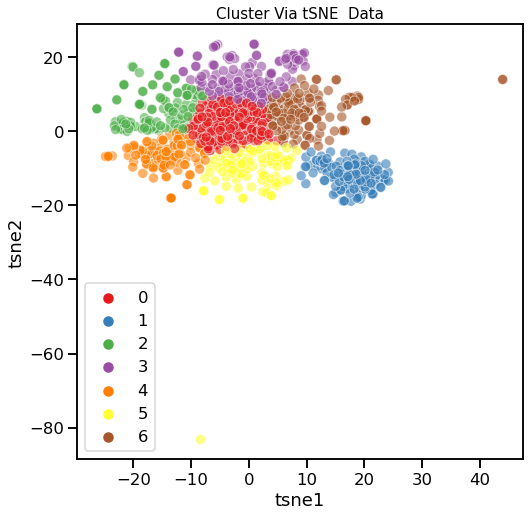

Adjusted Rand Index: 0.283


In [56]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_EfficientNetB2)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_EfficientNetB2'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_EfficientNetB2']
from sklearn import metrics
ari_EfficientNetB2 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [57]:
df_image.groupby('cluster_EfficientNetB1')['cat_1'].value_counts().to_frame()

cat_1
cluster_EfficientNetB1 cat_1                            
0                      Home Furnishing                59
                       Home Decor & Festive Needs     42
                       Kitchen & Dining               41
                       Baby Care                      35
                       Beauty and Personal Care       26
                       Computers                      23
                       Watches                         1
1                      Watches                       148
                       Computers                       4
                       Home Decor & Festive Needs      4
                       Beauty and Personal Care        3
2                      Kitchen & Dining               52
                       Home Furnishing                23
                       Beauty and Personal Care       19
                       Computers                      18
                       Home Decor & Festive Needs     12
                       Baby Care                       4
                       Watches                         1
3                      Home Furnishing                61
                       Computers                      41
                       Baby Care                      20
                       Home Decor & Festive Needs     19
                       Kitchen & Dining                6
                       Beauty and Personal Care        3
4                      Beauty and Personal Care       94
                       Kitchen & Dining               19
                       Computers                      16
                       Baby Care                       2
                       Home Decor & Festive Needs      1
                       Home Furnishing                 1
5                      Home Decor & Festive Needs     46
                       Kitchen & Dining               30
                       Computers                      23
                       Baby Care                       3
                       Home Furnishing                 2
6                      Baby Care                      86
                       Home Decor & Festive Needs     26
                       Computers                      25
                       Beauty and Personal Care        5
                       Home Furnishing                 4
                       Kitchen & Dining                2


accuracy: 50.1%


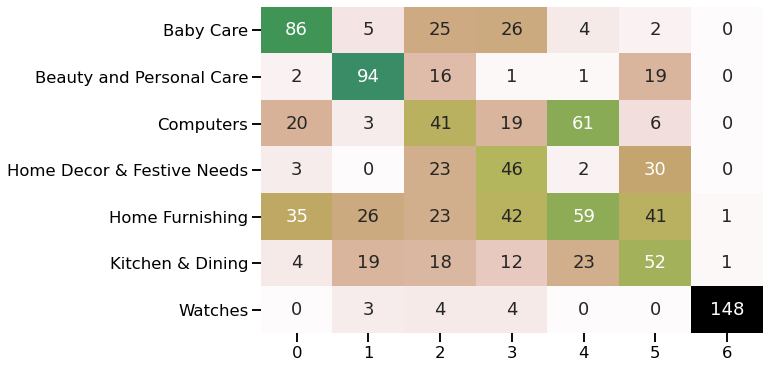

                            precision    recall  f1-score   support

                 Baby Care       0.57      0.58      0.58       148
  Beauty and Personal Care       0.63      0.71      0.66       133
                 Computers       0.27      0.27      0.27       150
Home Decor & Festive Needs       0.31      0.44      0.36       104
           Home Furnishing       0.39      0.26      0.31       227
          Kitchen & Dining       0.35      0.40      0.37       129
                   Watches       0.99      0.93      0.96       159

                  accuracy                           0.50      1050
                 macro avg       0.50      0.51      0.50      1050
              weighted avg       0.51      0.50      0.50      1050



In [68]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1']
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(0, 'Home Furnishing')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(1, 'Watches')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(2, 'Kitchen & Dining')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(3, 'Computers')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(4, 'Beauty and Personal Care')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(5, 'Home Decor & Festive Needs')
df_image['cluster_EfficientNetB1_label'] = df_image['cluster_EfficientNetB1_label'].replace(6, 'Baby Care')
categories_predict = df_image['cluster_EfficientNetB1_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">7. InceptionV3<span>

In [61]:
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
model = InceptionV3(include_top=False, weights="imagenet")
model.summary()

InceptionV3_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    InceptionV3_feature = model.predict(img_data)
    InceptionV3_feature_np = np.array(InceptionV3_feature)
    InceptionV3_feature_list.append(InceptionV3_feature_np.flatten())
        
InceptionV3_feature_list_np = np.array(InceptionV3_feature_list)

87916544/87910968 [==============================] - 56s 1us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 3 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, None, None, 3 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_4[0][0]      
_____________________

In [62]:
#Extraction des données du dataframe
df_image["InceptionV3"] =  ""

for i in range(df_image.shape[0]):
    df_image["InceptionV3"][i] = InceptionV3_feature_list_np[i]
    
df_InceptionV3 = extract_data("InceptionV3")
print("Taille vecteurs InceptionV3 :", df_InceptionV3.shape[1])

df_image.head()

Taille vecteurs InceptionV3 : 51200


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  ...  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...  ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   

                                         MobileNetV2 cluster_MobileNetV2  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   1   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   0   
2  [0.0, 0.0, 0.0, 2.483614, 0.0, 0.0, 0.0, 0.0, ...                   0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                   4   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8401828,...                   4   

  cluster_MobileNetV2_label  \
0          Kitchen & Dining   
1           Home Furnishing   
2           Home Furnishing   
3                 Baby Care   
4                 Baby Care   

                                          ResNet50V2 cluster_ResNet50V2  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  3   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                  6   

  EfficientNetB1  cluster_EfficientNetB1  \
0              4                       2   
1              3                       3   
2              3                       3   
3              0                       0   
4              0                       0   

                                      EfficientNetB2  \
0  [-0.17266521, -0.25197843, -0.2138637, -0.1788...   
1  [-0.26910874, -0.2768509, -0.18057586, -0.2347...   
2  [-0.2783397, -0.16286002, -0.26908267, -0.0833...   
3  [-0.27594927, -0.22437333, -0.11635258, -0.261...   
4  [-0.15716483, -0.2780

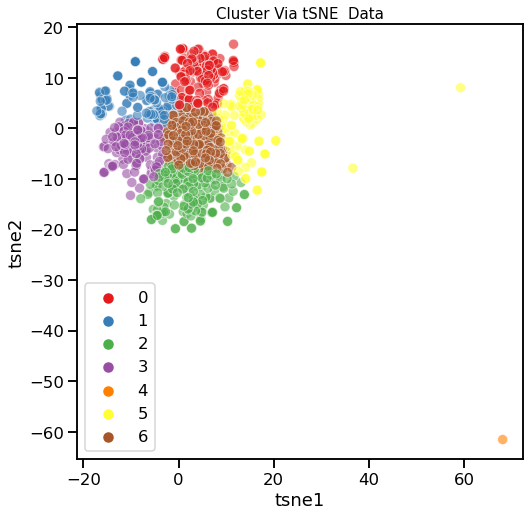

Adjusted Rand Index: 0.366


In [63]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_InceptionV3)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_InceptionV3'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_InceptionV3']
from sklearn import metrics
ari_InceptionV3 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [64]:
df_image.groupby('cluster_InceptionV3')['cat_1'].value_counts().to_frame()

cat_1
cluster_InceptionV3 cat_1                            
0                   Beauty and Personal Care      125
                    Kitchen & Dining               21
                    Computers                       8
                    Baby Care                       5
                    Home Decor & Festive Needs      3
1                   Computers                      89
                    Kitchen & Dining               24
                    Beauty and Personal Care        2
                    Watches                         2
                    Baby Care                       1
                    Home Decor & Festive Needs      1
2                   Home Furnishing                93
                    Baby Care                      59
                    Home Decor & Festive Needs     11
                    Computers                       8
                    Beauty and Personal Care        7
                    Kitchen & Dining                6
3                   Watches                       142
                    Baby Care                      24
                    Home Decor & Festive Needs     14
                    Beauty and Personal Care        4
                    Computers                       3
                    Kitchen & Dining                2
                    Home Furnishing                 1
4                   Computers                       1
5                   Kitchen & Dining               88
                    Home Decor & Festive Needs     28
                    Computers                      10
                    Home Furnishing                 4
                    Baby Care                       2
                    Beauty and Personal Care        2
                    Watches                         2
6                   Home Decor & Festive Needs     93
                    Baby Care                      59
                    Home Furnishing                52
                    Computers                      31
                    Beauty and Personal Care       10
                    Kitchen & Dining                9
                    Watches                         4


accuracy: 60.0%


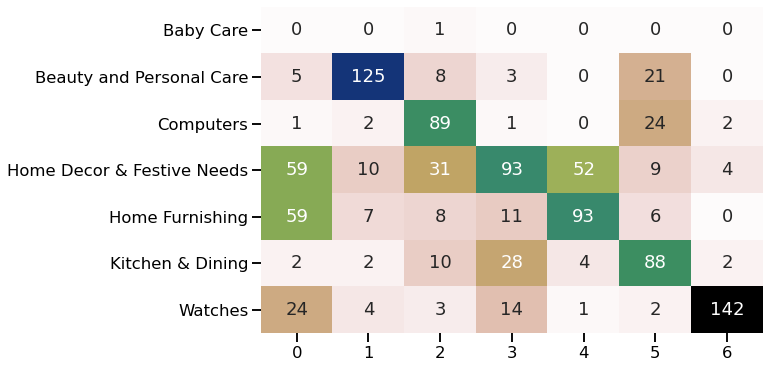

                            precision    recall  f1-score   support

                 Baby Care       0.00      0.00      0.00         1
  Beauty and Personal Care       0.83      0.77      0.80       162
                 Computers       0.59      0.75      0.66       119
Home Decor & Festive Needs       0.62      0.36      0.46       258
           Home Furnishing       0.62      0.51      0.56       184
          Kitchen & Dining       0.59      0.65      0.62       136
                   Watches       0.95      0.75      0.84       190

                  accuracy                           0.60      1050
                 macro avg       0.60      0.54      0.56      1050
              weighted avg       0.70      0.60      0.64      1050



In [69]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3']
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3_label'].replace(0, 'Beauty and Personal Care')
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3_label'].replace(1, 'Computers')
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3_label'].replace(2, 'Home Furnishing')
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3_label'].replace(3, 'Watches')
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3_label'].replace(4, 'Baby Care')
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3_label'].replace(5, 'Kitchen & Dining')
df_image['cluster_InceptionV3_label'] = df_image['cluster_InceptionV3_label'].replace(6, 'Home Decor & Festive Needs')
categories_predict = df_image['cluster_InceptionV3_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">8. InceptionResNetV2<span>

In [70]:
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications import InceptionResNetV2
model = InceptionResNetV2(include_top=False, weights="imagenet")
model.summary()

InceptionResNetV2_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    InceptionResNetV2_feature = model.predict(img_data)
    InceptionResNetV2_feature_np = np.array(InceptionResNetV2_feature)
    InceptionResNetV2_feature_list.append(InceptionResNetV2_feature_np.flatten())
        
InceptionResNetV2_feature_list_np = np.array(InceptionResNetV2_feature_list)

219062272/219055592 [==============================] - 144s 1us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 3 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, None, None, 3 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_98[0][0]     
___________

                                                                 block8_6_conv[0][0]              
__________________________________________________________________________________________________
block8_6_ac (Activation)        (None, None, None, 2 0           block8_6[0][0]                   
__________________________________________________________________________________________________
conv2d_286 (Conv2D)             (None, None, None, 1 399360      block8_6_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_286 (BatchN (None, None, None, 1 576         conv2d_286[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 1 0           batch_normalization_286[0][0]    
__________________________________________________________________________________________________
conv2d_287

In [71]:
#Extraction des données du dataframe
df_image["InceptionResNetV2"] =  ""

for i in range(df_image.shape[0]):
    df_image["InceptionResNetV2"][i] = InceptionResNetV2_feature_list_np[i]
    
df_InceptionResNetV2 = extract_data("InceptionResNetV2")
print("Taille vecteurs InceptionResNetV2 :", df_InceptionResNetV2.shape[1])

df_image.head()

Taille vecteurs InceptionResNetV2 : 38400


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  ...  cluster_ResNet50V2  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...                   3   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...                   6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...  ...                   6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...                   6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...                   6   

  EfficientNetB1 cluster_EfficientNetB1  \
0              4                      2   
1              3                      3   
2              3                      3   
3              0                      0   
4              0                      0   

                                      EfficientNetB2  \
0  [-0.17266521, -0.25197843, -0.2138637, -0.1788...   
1  [-0.26910874, -0.2768509, -0.18057586, -0.2347...   
2  [-0.2783397, -0.16286002, -0.26908267, -0.0833...   
3  [-0.27594927, -0.22437333, -0.11635258, -0.261...   
4  [-0.15716483, -0.27807692, -0.2652758, -0.2742...   

  cluster_EfficientNetB1_label  \
0             Kitchen & Dining   
1                    Computers   
2                    Computers   
3              Home Furnishing   
4              Home Furnishing   

                                         InceptionV3  cluster_InceptionV3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37719852, 0.2...                    2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.5270035, 0.0, 0.0,...                    6   
2  [0.0, 0.0, 0.0, 0.47240528, 0.0, 0.34458405, 0...                    6   
3  [0.0, 0.33043614, 0.0, 0.0, 0.0, 0.0, 0.501180...                    2   
4  [0.13395852, 0.21982664, 0.9325304, 0.0, 0.0, ...                    2   

   cluster_ResNet50V2_label   cluster_InceptionV3_label  \
0          Kitchen & Dining             Home Furnishing   
1           Home Furnishing  Home Decor & Festive Needs   
2           Home Furnishing  Home Decor & Festive Needs   
3           Home Furnishing             Home

In [103]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_InceptionResNetV2)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_InceptionResNetV2'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_InceptionResNetV2']
from sklearn import metrics
ari_InceptionResNetV2 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

NameError: name 'df_InceptionResNetV2' is not defined

In [73]:
df_image.groupby('cluster_InceptionResNetV2')['cat_1'].value_counts().to_frame()

cat_1
cluster_InceptionResNetV2 cat_1                            
0                         Baby Care                      70
                          Home Furnishing                41
                          Home Decor & Festive Needs     28
                          Beauty and Personal Care       19
                          Kitchen & Dining                7
                          Computers                       3
1                         Watches                       150
                          Computers                      28
                          Home Decor & Festive Needs     13
                          Kitchen & Dining               12
                          Beauty and Personal Care       10
                          Baby Care                       7
2                         Computers                      89
                          Baby Care                       2
                          Home Decor & Festive Needs      2
                          Beauty and Personal Care        1
                          Kitchen & Dining                1
3                         Home Furnishing               102
                          Baby Care                      26
                          Home Decor & Festive Needs     14
                          Kitchen & Dining                3
                          Beauty and Personal Care        2
                          Computers                       1
4                         Kitchen & Dining              109
                          Home Decor & Festive Needs     15
                          Baby Care                       8
                          Beauty and Personal Care        2
                          Computers                       1
5                         Beauty and Personal Care      111
                          Kitchen & Dining               12
                          Baby Care                       4
                          Computers                       4
                          Home Decor & Festive Needs      3
6                         Home Decor & Festive Needs     75
                          Baby Care                      33
                          Computers                      24
                          Home Furnishing                 7
                          Kitchen & Dining                6
                          Beauty and Personal Care        5


accuracy: 67.24%


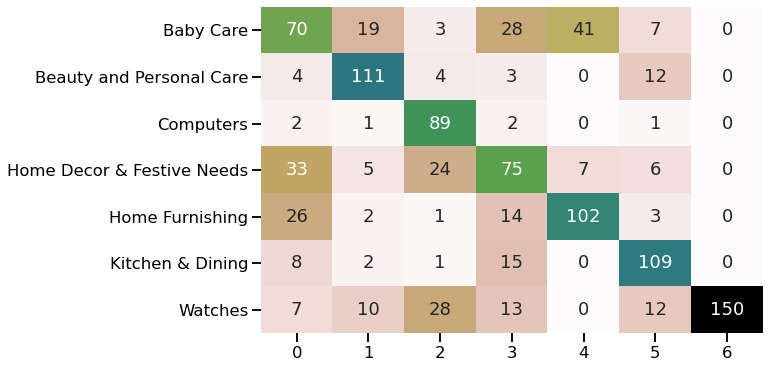

                            precision    recall  f1-score   support

                 Baby Care       0.47      0.42      0.44       168
  Beauty and Personal Care       0.74      0.83      0.78       134
                 Computers       0.59      0.94      0.73        95
Home Decor & Festive Needs       0.50      0.50      0.50       150
           Home Furnishing       0.68      0.69      0.68       148
          Kitchen & Dining       0.73      0.81      0.76       135
                   Watches       1.00      0.68      0.81       220

                  accuracy                           0.67      1050
                 macro avg       0.67      0.69      0.67      1050
              weighted avg       0.69      0.67      0.67      1050



In [74]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2']
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2_label'].replace(0, 'Baby Care')
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2_label'].replace(1, 'Watches')
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2_label'].replace(2, 'Computers')
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2_label'].replace(3, 'Home Furnishing')
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2_label'].replace(4, 'Kitchen & Dining')
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2_label'].replace(5, 'Beauty and Personal Care')
df_image['cluster_InceptionResNetV2_label'] = df_image['cluster_InceptionResNetV2_label'].replace(6, 'Home Decor & Festive Needs')
categories_predict = df_image['cluster_InceptionResNetV2_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">9. VGG19<span>

In [75]:
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import VGG19
model = VGG19(include_top=False, weights="imagenet")
model.summary()

VGG19_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    VGG19_feature = model.predict(img_data)
    VGG19_feature_np = np.array(VGG19_feature)
    VGG19_feature_list.append(VGG19_feature_np.flatten())
        
VGG19_feature_list_np = np.array(VGG19_feature_list)

80142336/80134624 [==============================] - 50s 1us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________________

In [76]:
#Extraction des données du dataframe
df_image["VGG19"] =  ""

for i in range(df_image.shape[0]):
    df_image["VGG19"][i] = VGG19_feature_list_np[i]
    
df_VGG19 = extract_data("VGG19")
print("Taille vecteurs VGG19 :", df_VGG19.shape[1])

df_image.head()

Taille vecteurs VGG19 : 25088


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  ...  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...  ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   

                                      EfficientNetB2  \
0  [-0.17266521, -0.25197843, -0.2138637, -0.1788...   
1  [-0.26910874, -0.2768509, -0.18057586, -0.2347...   
2  [-0.2783397, -0.16286002, -0.26908267, -0.0833...   
3  [-0.27594927, -0.22437333, -0.11635258, -0.261...   
4  [-0.15716483, -0.27807692, -0.2652758, -0.2742...   

  cluster_EfficientNetB1_label  \
0             Kitchen & Dining   
1                    Computers   
2                    Computers   
3              Home Furnishing   
4              Home Furnishing   

                                         InceptionV3  cluster_InceptionV3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37719852, 0.2...                    2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.5270035, 0.0, 0.0,...                    6   
2  [0.0, 0.0, 0.0, 0.47240528, 0.0, 0.34458405, 0...                    6   
3  [0.0, 0.33043614, 0.0, 0.0, 0.0, 0.0, 0.501180...                    2   
4  [0.13395852, 0.21982664, 0.9325304, 0.0, 0.0, ...                    2   

  cluster_ResNet50V2_label   cluster_InceptionV3_label  \
0         Kitchen & Dining             Home Furnishing   
1          Home Furnishing  Home Decor & Festive Needs   
2          Home Furnishing  Home Decor & Festive Needs   
3          Home Furnishing             Home Furnishing   
4          Home Furnishing             Home Furnishing   

                                   InceptionResNetV2  \
0  [0.24813765, 0.017267186, 0.0, 0.0, 0.956469, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.20620865, 0.0, 0.0, 0.0...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.05993038, 0.0, 0.0,

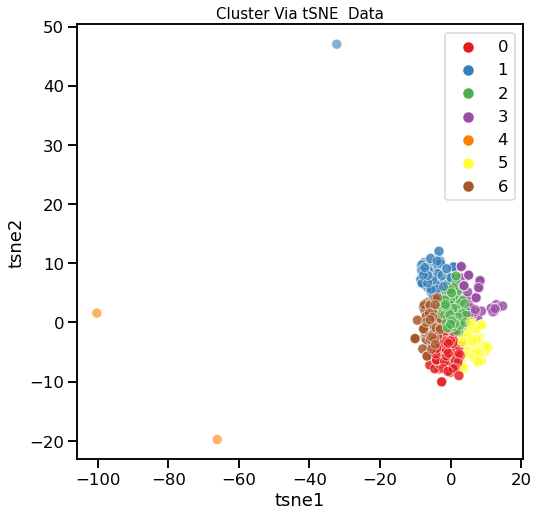

Adjusted Rand Index: 0.317


In [77]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_VGG19)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_VGG19'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_VGG19']
from sklearn import metrics
ari_VGG19 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [78]:
df_image.groupby('cluster_VGG19')['cat_1'].value_counts().to_frame()

cat_1
cluster_VGG19 cat_1                            
0             Baby Care                     101
              Home Furnishing                80
              Home Decor & Festive Needs     15
              Beauty and Personal Care        6
              Watches                         1
1             Watches                       135
              Computers                       4
              Kitchen & Dining                3
              Home Decor & Festive Needs      2
              Baby Care                       1
2             Computers                     118
              Home Decor & Festive Needs     70
              Home Furnishing                35
              Beauty and Personal Care       32
              Baby Care                      30
              Kitchen & Dining               21
              Watches                        12
3             Kitchen & Dining               80
              Computers                      15
              Beauty and Personal Care        7
              Home Furnishing                 5
              Baby Care                       2
4             Beauty and Personal Care        1
              Home Decor & Festive Needs      1
5             Beauty and Personal Care       99
              Home Furnishing                 9
              Home Decor & Festive Needs      6
              Kitchen & Dining                4
              Computers                       2
              Baby Care                       1
6             Home Decor & Festive Needs     56
              Kitchen & Dining               42
              Home Furnishing                21
              Baby Care                      15
              Computers                      11
              Beauty and Personal Care        5
              Watches                         2


accuracy: 56.1%


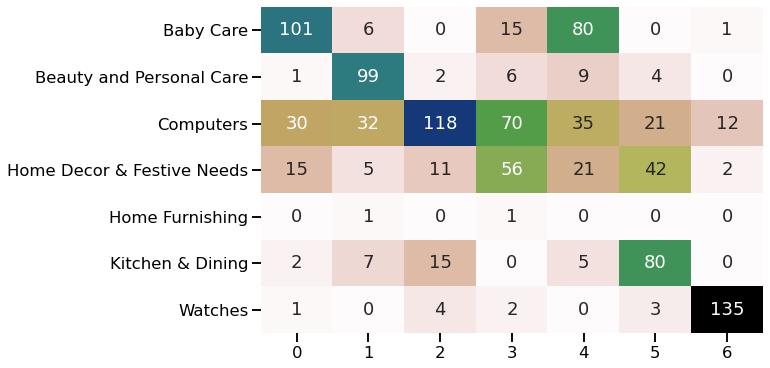

                            precision    recall  f1-score   support

                 Baby Care       0.67      0.50      0.57       203
  Beauty and Personal Care       0.66      0.82      0.73       121
                 Computers       0.79      0.37      0.50       318
Home Decor & Festive Needs       0.37      0.37      0.37       152
           Home Furnishing       0.00      0.00      0.00         2
          Kitchen & Dining       0.53      0.73      0.62       109
                   Watches       0.90      0.93      0.92       145

                  accuracy                           0.56      1050
                 macro avg       0.56      0.53      0.53      1050
              weighted avg       0.68      0.56      0.59      1050



In [79]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19']
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19_label'].replace(0, 'Baby Care')
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19_label'].replace(1, 'Watches')
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19_label'].replace(2, 'Computers')
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19_label'].replace(3, 'Kitchen & Dining')
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19_label'].replace(4, 'Home Furnishing')
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19_label'].replace(5, 'Beauty and Personal Care')
df_image['cluster_VGG19_label'] = df_image['cluster_VGG19_label'].replace(6, 'Home Decor & Festive Needs')
categories_predict = df_image['cluster_VGG19_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-info">10. DenseNet121<span>

In [80]:
from keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet121
model = DenseNet121(include_top=False, weights="imagenet")
model.summary()

DenseNet121_feature_list = []

for img_path in df_image["image"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    DenseNet121_feature = model.predict(img_data)
    DenseNet121_feature_np = np.array(DenseNet121_feature)
    DenseNet121_feature_list.append(DenseNet121_feature_np.flatten())
        
DenseNet121_feature_list_np = np.array(DenseNet121_feature_list)

29089792/29084464 [==============================] - 18s 1us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________

In [81]:
#Extraction des données du dataframe
df_image["DenseNet121"] =  ""

for i in range(df_image.shape[0]):
    df_image["DenseNet121"][i] = DenseNet121_feature_list_np[i]
    
df_DenseNet121 = extract_data("DenseNet121")
print("Taille vecteurs DenseNet121 :", df_DenseNet121.shape[1])

df_image.head()

Taille vecteurs DenseNet121 : 50176


image            cat_1  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                   image_redimension  \
0  Images_redimension/55b85ea15a1536d46b7190ad6ff...   
1  Images_redimension/7b72c92c2f6c40268628ec5f14c...   
2  Images_redimension/64d5d4a258243731dc7bbb1eef4...   
3  Images_redimension/d4684dcdc759dd9cdf41504698d...   
4  Images_redimension/6325b6870c54cd47be6ebfbffa6...   

                                               VGG16  cluster_VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 11.119317, 0.0, 0.0, 0.0,...              2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              6   

          cluster_VGG16_label  \
0                   Baby Care   
1  Home Decor & Festive Needs   
2                   Baby Care   
3                   Baby Care   
4                   Baby Care   

                                            Xception  cluster_Xception  \
0  [0.08515024, 0.0, 0.058781326, 0.0, 0.0, 0.0, ...                 2   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                 6   

       cluster_Xception_label  \
0  Home Decor & Festive Needs   
1             Home Furnishing   
2             Home Furnishing   
3             Home Furnishing   
4             Home Furnishing   

                                           MobileNet  ...  \
0  [3.019771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.419784, ...  ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...   

   cluster_InceptionV3 cluster_ResNet50V2_label   cluster_InceptionV3_label  \
0                    2         Kitchen & Dining             Home Furnishing   
1                    6          Home Furnishing  Home Decor & Festive Needs   
2                    6          Home Furnishing  Home Decor & Festive Needs   
3                    2          Home Furnishing             Home Furnishing   
4                    2          Home Furnishing             Home Furnishing   

                                   InceptionResNetV2  \
0  [0.24813765, 0.017267186, 0.0, 0.0, 0.956469, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.20620865, 0.0, 0.0, 0.0...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.05993038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   

  cluster_InceptionResNetV2 cluster_InceptionResNetV2_label  \
0                         3                 Home Furnishing   
1                         0                       Baby Care   
2                         3                 Home Furnishing   
3                         3                 Home Furnishing   
4                         3                 Home Furnishing   

                                               VGG19  cluster_VGG19  \
0  [0.0, 0.0, 0.0, 0.0, 4.87708, 29.630087, 0.0, ...              2   
1  [0.0, 0.0, 0.0, 0.0, 8.474036, 0.0, 0.0, 0.0, ...              6   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...              0   
4  [0.0, 0.0, 13.576062, 0.0, 0.0, 0.0, 0.0, 0.0,...              0   

          cluster_VGG19_label  \
0            

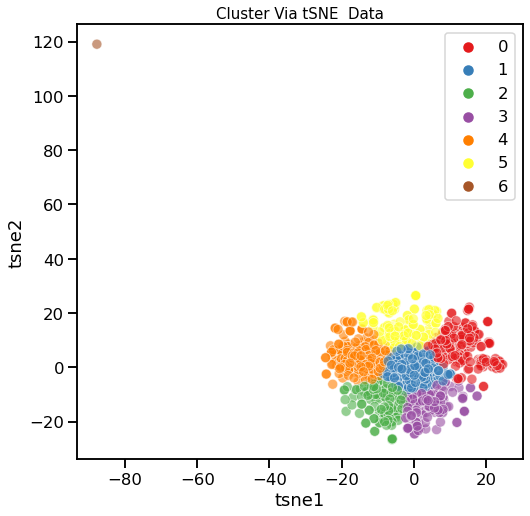

Adjusted Rand Index: 0.347


In [82]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_DenseNet121)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_DenseNet121'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_DenseNet121']
from sklearn import metrics
ari_DenseNet121 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [83]:
df_image.groupby('cluster_DenseNet121')['cat_1'].value_counts().to_frame()

cat_1
cluster_DenseNet121 cat_1                            
0                   Beauty and Personal Care      117
                    Kitchen & Dining               93
                    Computers                       8
                    Baby Care                       6
                    Home Decor & Festive Needs      6
1                   Home Furnishing                54
                    Home Decor & Festive Needs     42
                    Baby Care                      38
                    Computers                      24
                    Beauty and Personal Care       19
                    Kitchen & Dining                8
2                   Home Decor & Festive Needs     54
                    Home Furnishing                51
                    Baby Care                      12
                    Beauty and Personal Care        3
                    Computers                       1
                    Kitchen & Dining                1
3                   Baby Care                      89
                    Home Furnishing                42
                    Home Decor & Festive Needs     16
                    Computers                       3
                    Kitchen & Dining                3
                    Beauty and Personal Care        1
4                   Watches                       149
                    Home Decor & Festive Needs     26
                    Computers                      19
                    Kitchen & Dining                7
                    Beauty and Personal Care        6
                    Baby Care                       4
                    Home Furnishing                 3
5                   Computers                      95
                    Kitchen & Dining               38
                    Home Decor & Festive Needs      6
                    Beauty and Personal Care        4
                    Baby Care                       1
6                   Watches                         1


accuracy: 56.1%


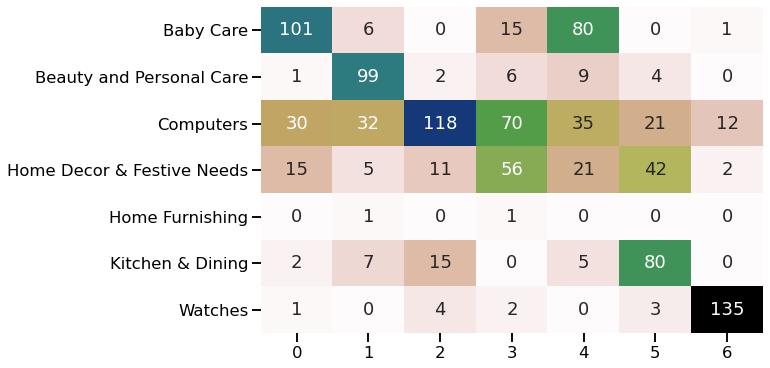

                            precision    recall  f1-score   support

                 Baby Care       0.67      0.50      0.57       203
  Beauty and Personal Care       0.66      0.82      0.73       121
                 Computers       0.79      0.37      0.50       318
Home Decor & Festive Needs       0.37      0.37      0.37       152
           Home Furnishing       0.00      0.00      0.00         2
          Kitchen & Dining       0.53      0.73      0.62       109
                   Watches       0.90      0.93      0.92       145

                  accuracy                           0.56      1050
                 macro avg       0.56      0.53      0.53      1050
              weighted avg       0.68      0.56      0.59      1050



In [79]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121']
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121_label'].replace(0, 'Baby Care')
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121_label'].replace(1, 'Watches')
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121_label'].replace(2, 'Computers')
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121_label'].replace(3, 'Kitchen & Dining')
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121_label'].replace(4, 'Home Furnishing')
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121_label'].replace(5, 'Beauty and Personal Care')
df_image['cluster_DenseNet121_label'] = df_image['cluster_DenseNet121_label'].replace(6, 'Home Decor & Festive Needs')
categories_predict = df_image['cluster_DenseNet121_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

## <span class="bg-primary">B.ESSAI :Xception avec images augmentées<span>

In [108]:
def process_image_albumentation(img):
    
    file_dir=os.path.split(img)
    figure = cv2.imread(img)
    figure = transform(image=figure)['image']
    
    #save image
    cv2.imwrite("Albumentation/"+file_dir[1], figure)
    
    return "Albumentation/"+file_dir[1]

In [113]:
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df_image = df[['image','product_category_tree']]
df_image['cat_1']=df_image['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])
del df_image['product_category_tree']
df_image["image"] = df_image["image"].apply(path)

### <span class="bg-success"> Essais avec Albumentation<span> 

In [114]:
transform = A.Compose([
    #A.CLAHE(clip_limit=2.4),
    A.CLAHE ()
    #A.Equalize (mode='cv', by_channels=True, mask=None, mask_params=())
    #A.FancyPCA (alpha=0.1)
    #A.IAAEmboss(),
    #A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
    #A.JpegCompression(quality_lower=59, quality_upper=60, always_apply=False, p=0.5),
    #A.HorizontalFlip(always_apply=False, p=0.5),
    #A.RandomBrightness(limit=0.3, always_apply=False, p=0.5),
])

In [116]:
# Prétraitement sur image originale
df_image["augmented_image"] = df_image["image"].apply(process_image_albumentation)

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Taille vecteurs Xception : 100352


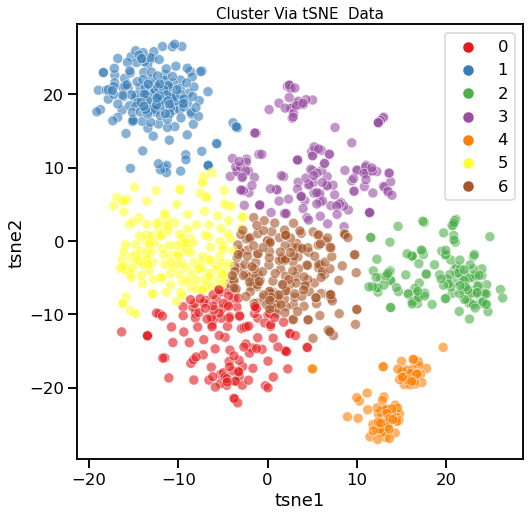

Adjusted Rand Index: 0.442


cat_1
cluster_Xception cat_1                            
0                Home Decor & Festive Needs     58
                 Home Furnishing                58
                 Baby Care                       6
                 Beauty and Personal Care        6
                 Computers                       1
                 Kitchen & Dining                1
                 Watches                         1
1                Watches                       149
                 Home Decor & Festive Needs     11
                 Computers                       6
                 Kitchen & Dining                6
                 Beauty and Personal Care        5
                 Baby Care                       1
2                Beauty and Personal Care      112
                 Kitchen & Dining               16
                 Baby Care                       5
                 Computers                       2
3                Computers                     114
                 Kitchen & Dining               30
                 Beauty and Personal Care        7
                 Home Decor & Festive Needs      4
                 Baby Care                       3
4                Kitchen & Dining               79
                 Baby Care                       3
                 Beauty and Personal Care        1
5                Baby Care                     109
                 Home Decor & Festive Needs     29
                 Home Furnishing                14
                 Kitchen & Dining               10
                 Computers                       5
                 Beauty and Personal Care        3
6                Home Furnishing                78
                 Home Decor & Festive Needs     48
                 Baby Care                      23
                 Computers                      22
                 Beauty and Personal Care       16
                 Kitchen & Dining                8

In [117]:
from keras.applications.xception import preprocess_input
from keras.applications import Xception
model = Xception(include_top=False, weights="imagenet")
model.summary()

xception_feature_list = []

for img_path in df_image["augmented_image"]:
    # load the input image, convert it to a NumPy array, and then
    # reshape it to have an extra dimension
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    xception_feature = model.predict(img_data)
    xception_feature_np = np.array(xception_feature)
    xception_feature_list.append(xception_feature_np.flatten())
        
xception_feature_list_np = np.array(xception_feature_list)

#Extraction des données du dataframe
df_image["Xception"] =  ""

for i in range(df_image.shape[0]):
    df_image["Xception"][i] = xception_feature_list_np[i]
    
df_Xception = extract_data("Xception")
print("Taille vecteurs Xception :", df_Xception.shape[1])

df_image.head()

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_Xception)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df_image['cluster_Xception'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_Xception']
from sklearn import metrics
ari_Xception16 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

df_image.groupby('cluster_Xception')['cat_1'].value_counts().to_frame()

## <span class="bg-primary">C.ESSAI : Combinaisons données textuelles + données visuelles<span>

Nous allons faire un essai en combinant les deux modèles les plus performants :
- Données textuelles : USE (ARI = 0.73)
- Données visuelles : Xception (ARI = 0.51)

In [118]:
df1 = pd.read_csv('df_USE_512.csv')
del df1['Unnamed: 0']
df2 = pd.read_csv('Xception.csv')
del df2['Unnamed: 0']

In [191]:
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
df1_tsne = tsne.fit_transform(df1)
tsne_df1 = pd.DataFrame(df1_tsne, columns=['tsne1', 'tsne2'])


df2_tsne = tsne.fit_transform(df2)
tsne_df2 = pd.DataFrame(df2_tsne, columns=['tsne1', 'tsne2'])

In [192]:
df_total_tsne = pd.concat([tsne_df1, tsne_df2], axis=1,ignore_index=True)

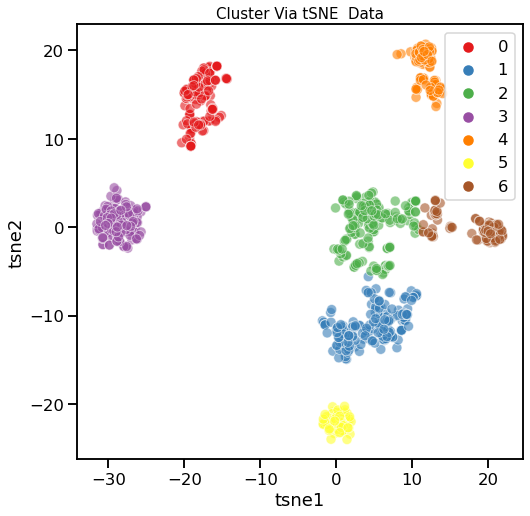

In [193]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_total_tsne)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

In [194]:
#Metrics ARI
df_image['cluster_Total5'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_Total5']
from sklearn import metrics
ari_MobileNetV2 = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Adjusted Rand Index: 0.667


In [195]:
df_image.groupby('cluster_Total5')['cat_1'].value_counts().to_frame()

cat_1
cluster_Total5 cat_1                            
0              Computers                     147
               Kitchen & Dining                7
               Beauty and Personal Care        5
               Home Decor & Festive Needs      2
1              Home Furnishing               142
               Baby Care                      42
               Beauty and Personal Care       12
               Home Decor & Festive Needs      9
               Kitchen & Dining                5
2              Home Decor & Festive Needs    124
               Kitchen & Dining               31
               Baby Care                      17
               Beauty and Personal Care       10
               Home Furnishing                 8
3              Watches                       150
               Home Decor & Festive Needs      3
4              Beauty and Personal Care      122
               Baby Care                       3
               Computers                       2
5              Baby Care                      85
               Beauty and Personal Care        1
6              Kitchen & Dining              107
               Home Decor & Festive Needs     12
               Baby Care                       3
               Computers                       1


accuracy: 83.52%


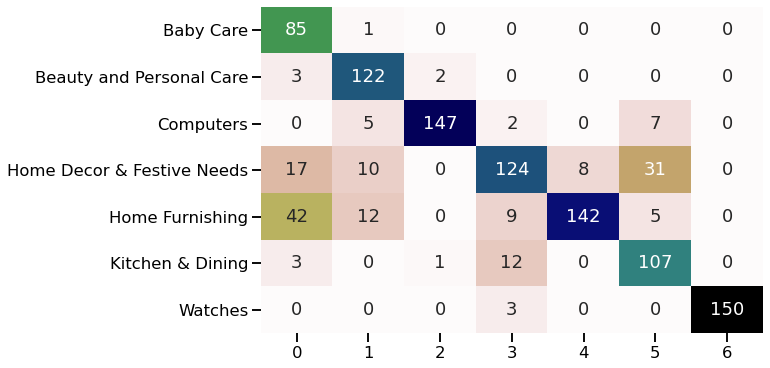

                            precision    recall  f1-score   support

                 Baby Care       0.57      0.99      0.72        86
  Beauty and Personal Care       0.81      0.96      0.88       127
                 Computers       0.98      0.91      0.95       161
Home Decor & Festive Needs       0.83      0.65      0.73       190
           Home Furnishing       0.95      0.68      0.79       210
          Kitchen & Dining       0.71      0.87      0.78       123
                   Watches       1.00      0.98      0.99       153

                  accuracy                           0.84      1050
                 macro avg       0.84      0.86      0.83      1050
              weighted avg       0.86      0.84      0.84      1050



In [198]:
#Catégories des différents clusters + Matrice de confusion
df_image['cluster_Total5_label'] = df_image['cluster_Total5']
df_image['cluster_Total5_label'] = df_image['cluster_Total5_label'].replace(0, 'Computers')
df_image['cluster_Total5_label'] = df_image['cluster_Total5_label'].replace(1, 'Home Furnishing')
df_image['cluster_Total5_label'] = df_image['cluster_Total5_label'].replace(2, 'Home Decor & Festive Needs')
df_image['cluster_Total5_label'] = df_image['cluster_Total5_label'].replace(3, 'Watches')
df_image['cluster_Total5_label'] = df_image['cluster_Total5_label'].replace(4, 'Beauty and Personal Care')
df_image['cluster_Total5_label'] = df_image['cluster_Total5_label'].replace(5, 'Baby Care')
df_image['cluster_Total5_label'] = df_image['cluster_Total5_label'].replace(6, 'Kitchen & Dining')
categories_predict = df_image['cluster_Total5_label']
categories_true = df_image['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

In [182]:
def plot_erreurs(cat_clust, cat_true, figsize=(8,4),
                palette='tab10', ylim=(0,250), bboxtoanchor=None):
    
    # pivot = data.drop(columns=['description','image'])
    pivot = pd.DataFrame()
    pivot['label']=cat_clust
    pivot['category']=cat_true
    pivot['count']=1
    pivot = pivot.groupby(by=['label','category']).count().unstack().fillna(0)
    pivot.columns=pivot.columns.droplevel()
    
    colors = sns.color_palette(palette, cat_clust.shape[0]).as_hex()
    pivot.plot.bar(width=0.8,stacked=True,legend=True,figsize=figsize,
                   color=colors, ec='k')
    plt.legend(bbox_to_anchor=bboxtoanchor)
        
    plt.show()    
    
    return pivot

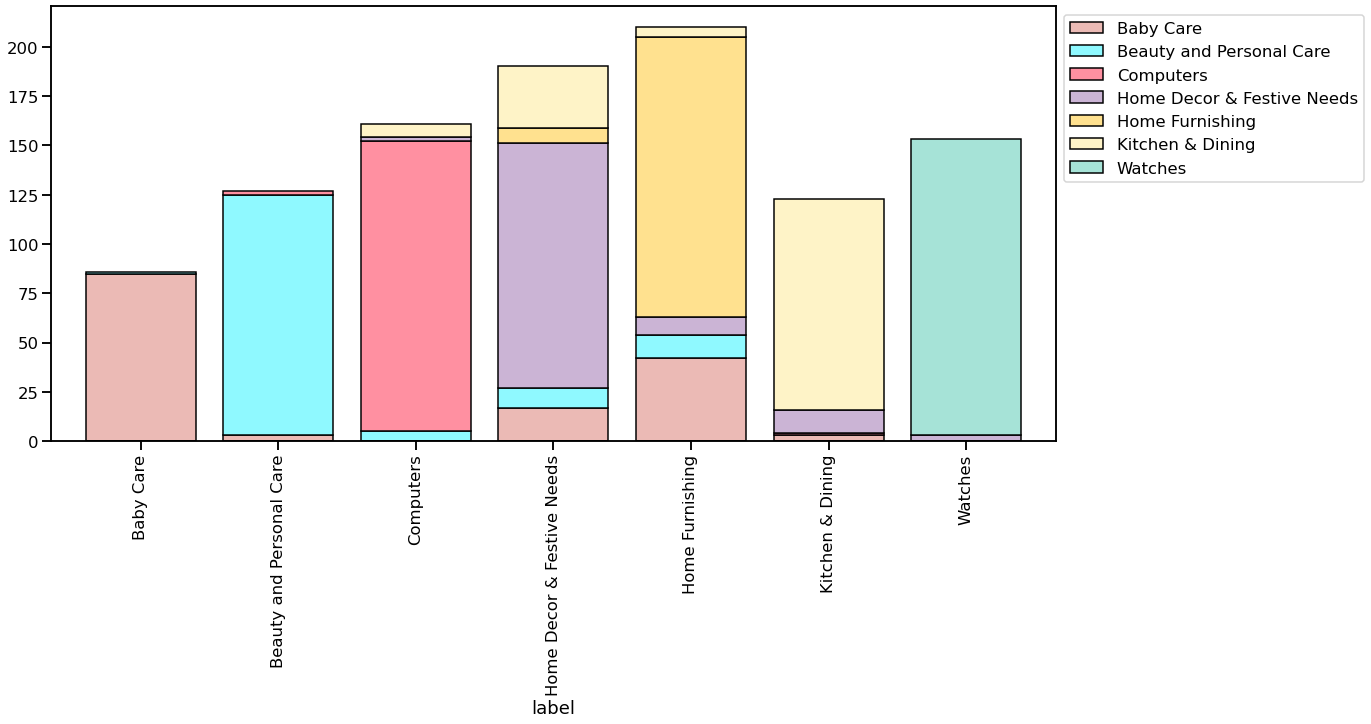

category                    Baby Care  Beauty and Personal Care  Computers  \
label                                                                        
Baby Care                        85.0                       1.0        0.0   
Beauty and Personal Care          3.0                     122.0        2.0   
Computers                         0.0                       5.0      147.0   
Home Decor & Festive Needs       17.0                      10.0        0.0   
Home Furnishing                  42.0                      12.0        0.0   
Kitchen & Dining                  3.0                       0.0        1.0   
Watches                           0.0                       0.0        0.0   

category                    Home Decor & Festive Needs  Home Furnishing  \
label                                                                     
Baby Care                                          0.0              0.0   
Beauty and Personal Care                           0.0              0.0   
Computers                                          2.0              0.0   
Home Decor & Festive Needs                       124.0              8.0   
Home Furnishing                                    9.0            142.0   
Kitchen & Dining                                  12.0              0.0   
Watches                                            3.0              0.0   

category                    Kitchen & Dining  Watches  
label                                                  
Baby Care                                0.0      0.0  
Beauty and Personal Care                 0.0      0.0  
Computers                                7.0      0.0  
Home Decor & Festive Needs              31.0      0.0  
Home Furnishing                          5.0      0.0  
Kitchen & Dining                       107.0      0.0  
Watches                                  0.0    150.0

In [199]:
plot_erreurs(df_image['cluster_Total5_label'],
                              df_image['cat_1'],
                              palette=['#EBBAB5', '#8FF9FF', '#FF90A1','#CBB4D5', '#FFE18F','#FEF3C7','#A6E3D7'],
                              figsize=(18,8),
                              bboxtoanchor=(1,1), ylim=(0,250))

## <span class="bg-primary">D.RESULTATS : récapitulation pour la conclusion<span>

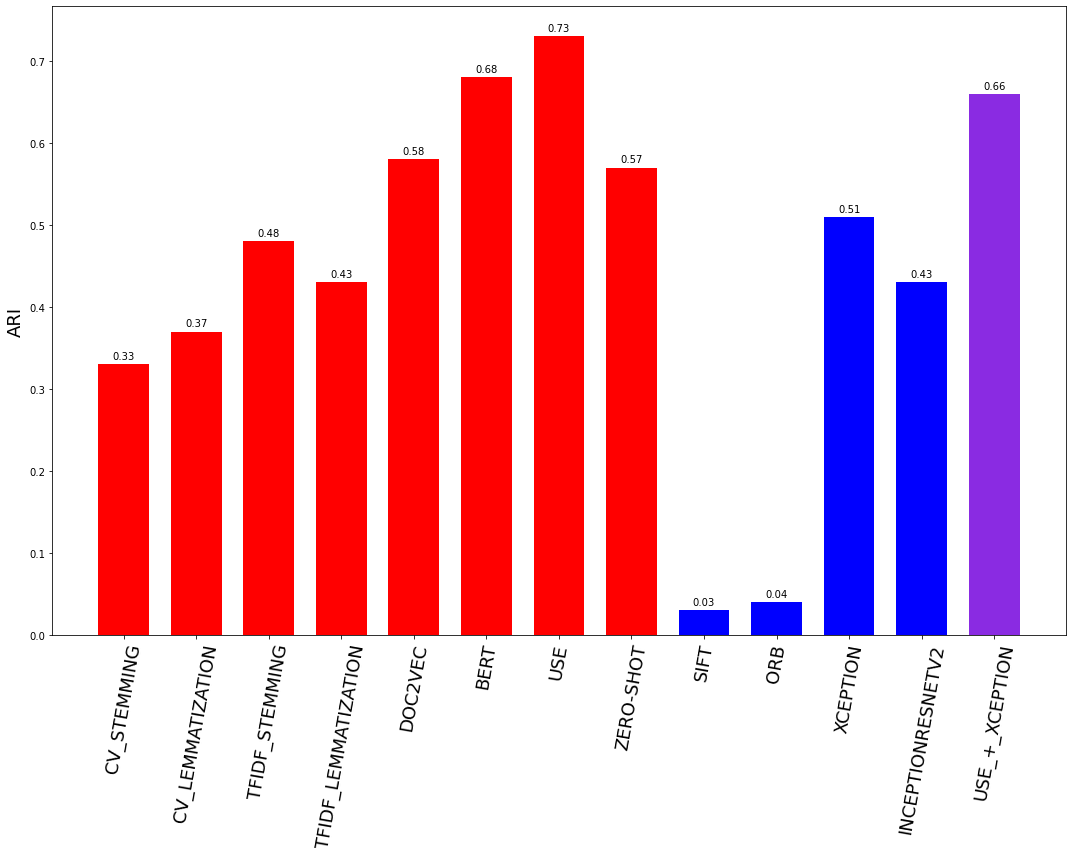

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['CV_STEMMING', 'CV_LEMMATIZATION','TFIDF_STEMMING', 'TFIDF_LEMMATIZATION','DOC2VEC', 
          'BERT', 'USE','ZERO-SHOT', 'SIFT', 'ORB', 'XCEPTION', 'INCEPTIONRESNETV2', 'USE_+_XCEPTION']
ARI = [0.33, 0.37, 0.48, 0.43, 0.58, 0.68, 0.73, 0.57, 0.03, 0.04, 0.51, 0.43, 0.66]

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars
fig, ax = plt.subplots(figsize = (15, 12))

rects = ax.bar(x, ARI, width, color = ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b','blueviolet'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ARI', fontsize=18)
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=18, rotation=80)
#ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)        
        

fig.tight_layout()

plt.show()